Analyzing the Drone Ocean Color Data in relation to MODIS Chla and SST 

In [1]:
import numpy as np
import xarray as xr
import os.path as op
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime
%matplotlib inline

import cartopy.crs as crs
import hvplot.xarray
import pandas as pd
import geopandas as gpd
import hvplot.pandas

import netCDF4
from netCDF4 import Dataset

from datetime import datetime, timedelta
import geopandas as gpd
import pandas as pd

from utils import *
from georeg import *

### Load in flight data

In [2]:
# flight 0
gdf0 = gpd.read_file('data/oc_analysis_20210826_A1_gulf_stream_surveys.shp')
gdf0['sst_c'] = gdf0['sst']-273.15
gdf0['time'] = pd.to_datetime(gdf0['time_str'])
gdf0['flight'] = 3
df0 = gdf0.drop('geometry', axis=1)

# flight 1
gdf1 = gpd.read_file('data/oc_analysis_20210827_A1_gulf_stream_surveys.shp')
gdf1['sst_c'] = gdf1['sst']-273.15
gdf1['time'] = pd.to_datetime(gdf1['time_str'])
gdf1['flight'] = 1
# for some reason I can't have the geometry column due to a bug in holoviz
df1 = gdf1.drop('geometry', axis=1)

# flight 2
gdf2 = gpd.read_file('data/oc_analysis_20210827_A2_gulf_stream_surveys.shp')
gdf2['time'] = pd.to_datetime(gdf2['time_str'])
gdf2['sst_c'] = gdf2['sst']-273.15
gdf2['flight'] = 2
df2 = gdf2.drop('geometry', axis=1)

# # flight 3
# gdf3 = gpd.read_file('data/oc_analysis_20210828_A1_gulf_stream_surveys.shp')
# gdf3['sst_c'] = gdf3['sst']-273.15
# gdf3['time'] = pd.to_datetime(gdf3['time_str'])
# gdf3['flight'] = 3
# df3 = gdf3.drop('geometry', axis=1)


# flight 3
gdf3 = gpd.read_file('data/oc_analysis_20210828_A2_gulf_stream_surveys.shp')
gdf3['sst_c'] = gdf3['sst']-273.15
gdf3['time'] = pd.to_datetime(gdf3['time_str'])
gdf3['flight'] = 3
df3 = gdf3.drop('geometry', axis=1)

uncert_gdf = gpd.read_file('data/oc_analysis_20210826_A1_trios_comparison_gulf_stream_surveys.shp')
uncert_gdf['sst_c'] = uncert_gdf['sst']-273.15
uncert_gdf['time'] = pd.to_datetime(gdf3['time_str'])
uncert_gdf['flight'] = 3
uncert_df = uncert_gdf.drop('geometry', axis=1)

# # flight 3
# gdf4 = gpd.read_file('chla_sst_flight4.shp')
# gdf4['sst_c'] = gdf4['sst']-273.15
# gdf4['time'] = pd.to_datetime(gdf4['time_str'])
# gdf4['flight'] = 4
# df4 = gdf4.drop('geometry', axis=1)

In [3]:
gdf1

chla   Latitude  Longitude    sst  \
0    0.243555  35.681433 -74.715933  28.81   
1    0.244307  35.681528 -74.716067  28.78   
2    0.243333  35.681628 -74.716214  28.80   
3    0.245878  35.681753 -74.716397  28.84   
4    0.245712  35.681836 -74.716519  28.85   
..        ...        ...        ...    ...   
402  0.250364  35.690972 -74.708306  25.20   
403  0.247254  35.690933 -74.708086  25.17   
404  0.246122  35.690892 -74.707867  25.10   
405  0.246245  35.690847 -74.707650  25.32   
406  0.246668  35.690803 -74.707442  25.38   

                                            lw_spectra             time_str  \
0    [0.00583681 0.00147552 0.00016475 0.00011772 0...  2021-08-27 13:41:27   
1    [0.0058161  0.00148619 0.00016646 0.00011926 0...  2021-08-27 13:41:29   
2    [0.00583272 0.00146564 0.00016654 0.00013286 0...  2021-08-27 13:41:31   
3    [0.00572643 0.00147576 0.00016713 0.0001462  0...  2021-08-27 13:41:34   
4    [0.00573585 0.00147627 0.0001652  0.00012774 0...  2021-08-27 13:41:35   
..                                                 ...                  ...   
402  [0.00586377 0.00168714 0.00016755 0.00015912 0...  2021-08-27 13:55:11   
403  [0.00603175 0.0016997  0.00017625 0.00020237 0...  2021-08-27 13:55:13   
404  [0.00609254 0.00169866 0.00016563 0.00016895 0...  2021-08-27 13:55:15   
405  [0.00606771 0.00168673 0.00016534 0.0001833  0...  2021-08-27 13:55:17   
406  [0.00606648 0.00170397 0.00018192 0.00019118 0...  2021-08-27 13:55:19   

                       geometry   sst_c                time  flight  
0    POINT (-74.71593 35.68143) -244.34 2021-08-27 13:41:27       1  
1    POINT (-74.71607 35.68153) -244.37 2021-08-27 13:41:29       1  
2    POINT (-74.71621 35.68163) -244.35 2021-08-27 13:41:31       1  
3    POINT (-74.71640 35.68175) -244.31 2021-08-27 13:41:34       1  
4    POINT (-74.71652 35.68184) -244.30 2021-08-27 13:41:35       1  
..                          ...     ...                 ...     ...  
402  POINT (-74.70831 35.69097) -247.95 2021-08-27 13:55:11       1  
403  POINT (-74.70809 35.69093) -247.98 2021-08-27 13:55:13       1  
404  POINT (-74.70787 35.69089) -248.05 2021-08-27 13:55:15       1  
405  POINT (-74.70765 35.69085) -247.83 2021-08-27 13:55:17       1  
406  POINT (-74.70744 35.69080) -247.77 2021-08-27 13:55:19       1  

[407 rows x 10 columns]

In [8]:
for my_gdf in [gdf0,gdf1,gdf2,gdf3, uncert_gdf]:
    update_chla = []
    all_spectra = []
    for x in my_gdf.lw_spectra:
    #     print('---next spec---')
        x = x[1:-1]
        if x[0] == ' ':
            x = x[1:]
        if x[-1] == ' ':
            x = x[:-1]
        x = x.replace('  ',' ')
        x = x.replace('\n','')
        spec = []
        for i in x.split(' '):
            if i == '' or i ==' ':
                pass
            else:
    #             print('i is:',i,'.')
                spec.append(float(i))
        if len(spec) != 5:
            print('weird')
        update_chla.append(oc_index(spec[0],spec[1],spec[2]))
        all_spectra.append(np.array(spec))
    my_gdf['lw_spectra_float'] = all_spectra
    my_gdf['chla'] = update_chla

In [9]:
# gdf_all_flights = pd.concat([gdf1,gdf2,gdf3,gdf4])
gdf_all_flights = pd.concat([gdf0,gdf1,gdf2,gdf3])
gdf_all_flights

chla   Latitude  Longitude    sst  \
0    0.169086  35.791556 -74.600636  27.27   
1    0.166861  35.791556 -74.600636  27.24   
2    0.169427  35.791556 -74.600633  27.14   
3    0.169595  35.791558 -74.600636  27.04   
4    0.168232  35.791603 -74.600661  27.20   
..        ...        ...        ...    ...   
183  0.225706  35.794922 -74.628264  27.85   
184  0.225298  35.794750 -74.628186  27.86   
185  0.224712  35.794583 -74.628094  27.85   
186  0.223575  35.794422 -74.627992  27.73   
187  0.222941  35.794244 -74.627869  27.73   

                                            lw_spectra             time_str  \
0    [4.88902001e-03 1.46889191e-03 1.40666728e-04 ...  2021-08-26 17:54:03   
1    [4.89128429e-03 1.43816144e-03 1.35672384e-04 ...  2021-08-26 17:54:05   
2    [0.00487394 0.00146758 0.00014799 0.00013832 0...  2021-08-26 17:54:07   
3    [4.85288633e-03 1.45863824e-03 1.50975128e-04 ...  2021-08-26 17:54:09   
4    [4.83728480e-03 1.43220403e-03 1.53532918e-04 ...  2021-08-26 17:54:11   
..                                                 ...                  ...   
183  [3.74772799e-03 1.47138022e-03 1.91274582e-04 ...  2021-08-28 19:34:26   
184  [3.73804814e-03 1.45922202e-03 1.85531933e-04 ...  2021-08-28 19:34:28   
185  [3.72742903e-03 1.44626777e-03 1.83604927e-04 ...  2021-08-28 19:34:30   
186  [3.74018684e-03 1.44395378e-03 1.87645598e-04 ...  2021-08-28 19:34:32   
187  [3.73376693e-03 1.42970332e-03 1.77833744e-04 ...  2021-08-28 19:34:34   

                       geometry   sst_c                time  flight  \
0    POINT (-74.60064 35.79156) -245.88 2021-08-26 17:54:03       3   
1    POINT (-74.60064 35.79156) -245.91 2021-08-26 17:54:05       3   
2    POINT (-74.60063 35.79156) -246.01 2021-08-26 17:54:07       3   
3    POINT (-74.60064 35.79156) -246.11 2021-08-26 17:54:09       3   
4    POINT (-74.60066 35.79160) -245.95 2021-08-26 17:54:11       3   
..                          ...     ...                 ...     ...   
183  POINT (-74.62826 35.79492) -245.30 2021-08-28 19:34:26       3   
184  POINT (-74.62819 35.79475) -245.29 2021-08-28 19:34:28       3   
185  POINT (-74.62809 35.79458) -245.30 2021-08-28 19:34:30       3   
186  POINT (-74.62799 35.79442) -245.42 2021-08-28 19:34:32       3   
187  POINT (-74.62787 35.79424) -245.42 2021-08-28 19:34:34       3   

                                      lw_spectra_float  
0    [0.00488902001, 0.00146889191, 0.000140666728,...  
1    [0.00489128429, 0.00143816144, 0.000135672384,...  
2    [0.00487394, 0.00146758, 0.00014799, 0.0001383...  
3    [0.00485288633, 0.00145863824, 0.000150975128,...  
4    [0.0048372848, 0.00143220403, 0.000153532918, ...  
..                                                 ...  
183  [0.00374772799, 0.00147138022, 0.000191274582,...  
184  [0.00373804814, 0.00145922202, 0.000185531933,...  
185  [0.00372742903, 0.00144626777, 0.000183604927,...  
186  [0.00374018684, 0.00144395378, 0.000187645598,...  
187  [0.00373376693, 0.00142970332, 0.000177833744,...  

[1142 rows x 11 columns]

In [94]:
np.mean(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[0]))

0.004788996155454546

In [95]:
np.std(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[0]))

1.566530462653835e-05

In [96]:
plt.rcParams.update({'font.size': 14})

In [10]:
stds_list = []
for i in range(5):
    stds_list.append(np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])))
stds_list

[7.183649882211773e-05,
 1.4519771838460445e-05,
 1.1312350851544899e-05,
 2.40048282267275e-05,
 1.047908321739266e-05]

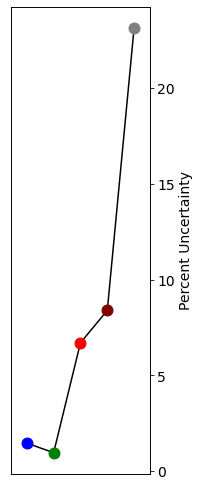

In [13]:
percent_diff_list = []
for i in range(5):
    percent_diff_list.append(np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])) / np.mean(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])))

fig, ax = plt.subplots(figsize=(3,7))
ax.set_yticks([])
ax = ax.twinx()
colors=['blue', 'green', 'red', 'grey','maroon']
ax.plot([percent_diff_list[i]*100 for i in [0,1,2,4,3]], color='black',zorder=0)

for idx, i in enumerate([0,1,2,4,3]):
    ax.scatter(idx,percent_diff_list[i]*100, color=colors[i],s=120,zorder=1)
#     ax.axhline(stds_list[i]*100,color=colors[i])
plt.ylabel('Percent Uncertainty')
# plt.ylim(0,20)
plt.xlim(-0.6, 4.6)
ax.set_xticks([])
fig.tight_layout()
plt.savefig('altum_uncertainty_per_band.png',dpi=300)
plt.show()

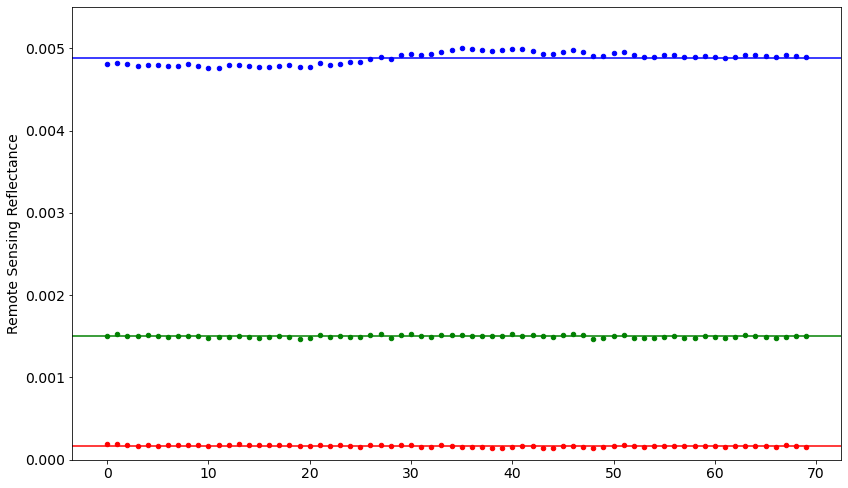

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
for i,c in [[0,'blue'],[1,'green'],[2, 'red']]:
    ax.scatter(np.arange(0,len(uncert_gdf)),uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i]),color=c,s=20)
#     ax.plot(np.arange(0,len(uncert_gdf)),uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])+np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
#     ax.plot(np.arange(0,len(uncert_gdf)),uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])-np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
    ax.axhline(np.mean(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])),c=c)
ax.set_ylabel('Remote Sensing Reflectance')
ax.set_ylim(0.000,0.01)
ax.set_ylim(0.000,0.0055)
# ax.set_ylim(0.000,0.0005)
fig.tight_layout()
plt.savefig('altum_uncertainty_across_time_different_ylim.png',dpi=300)

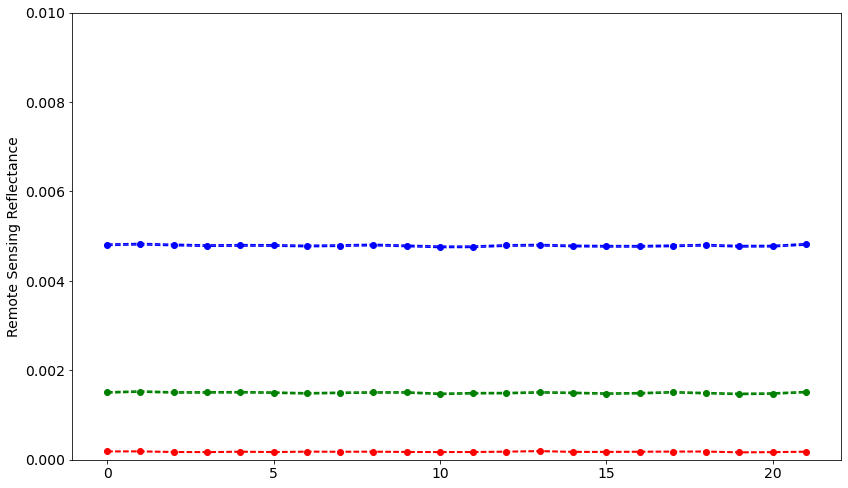

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
for i,c in [[0,'blue'],[1,'green'],[2, 'red']]:
    ax.scatter(np.arange(0,22),uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i]),color=c)
    ax.plot(np.arange(0,22),uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])+np.std(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
    ax.plot(np.arange(0,22),uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])-np.std(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
ax.set_ylabel('Remote Sensing Reflectance')
ax.set_ylim(0.000,0.01)
# ax.set_ylim(0.000,0.002)
# ax.set_ylim(0.000,0.0005)
fig.tight_layout()
plt.savefig('altum_uncertainty_across_time.png',dpi=300)

Now bring in the TriOS data and plot it together

In [15]:
trios_fns = [
    '../gs_front_analysis/data/ivan_cruise/trios/shearwater_trios_20210826.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210827.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210828.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210829.csv',
            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

In [16]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df = trios_df.set_index('utc_dt')

In [82]:
static_trios_df = trios_df.loc['2021-08-26 19:46:00':'2021-08-26 19:55:00']
len(static_trios_df)

55

In [83]:
spec = []
for i in range(len(static_trios_df)):
    static_trios_df.iloc[i,1:-1] = static_trios_df.iloc[i,1:-1] - np.mean(static_trios_df.iloc[i,-250:-1])

In [87]:
plt.rcParams.update({'font.size': 14})

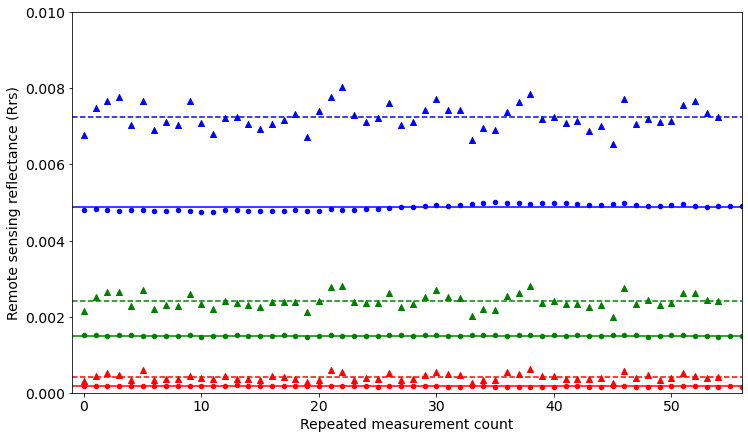

In [89]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    band_std = static_trios_df.iloc[:, l:u].mean(axis=1).std()
    
    
    ax.axhline(band_mean,color=c, ls='--')
#     ax.axhline(band_mean+band_std,color=c, ls='--')
#     ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1, marker='^')
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1)

for i,c in [[0,'blue'],[1,'green'],[2, 'red']]:
    ax.scatter(np.arange(0,len(uncert_gdf)),uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i]),color=c,s=20)
    
#     ax.axhline(np.mean(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i]))+np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
#     ax.axhline(np.mean(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i]))-np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
    
    ax.axhline(np.mean(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])),c=c)

ax.set_ylim(0,0.01)
ax.set_xlim(-1,56)

ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
fig.savefig('repeated_measurements_uas_trios.png',dpi=300)

In [203]:
blue_uncert = np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[0]))
green_uncert = np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[1]))
red_uncert = np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[2]))
blue_uncert, green_uncert, red_uncert

(7.183649882211773e-05, 1.4519771838460445e-05, 1.1312350851544899e-05)

In [79]:
uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[0]).mean()

0.004788996155454546

In [82]:
! pip install uncertainties

     |████████████████████████████████| 98 kB 2.3 MB/s eta 0:00:011


In [83]:
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

In [204]:
blue_u = ufloat(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[0]).mean(), blue_uncert)
green_u = ufloat(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[1]).mean(), green_uncert) 
red_u = ufloat(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[2]).mean(), red_uncert)

chla_u = oc_index(blue_u, green_u, red_u)

In [205]:
chla_u

0.1710075987301592+/-0.003396502377431248

In [206]:
chla_u.s/chla_u.nominal_value

0.019861704407596218

In [123]:
chla_u.s/chla_u.nominal_value

0.007291857550913465

0.0012726837554679123

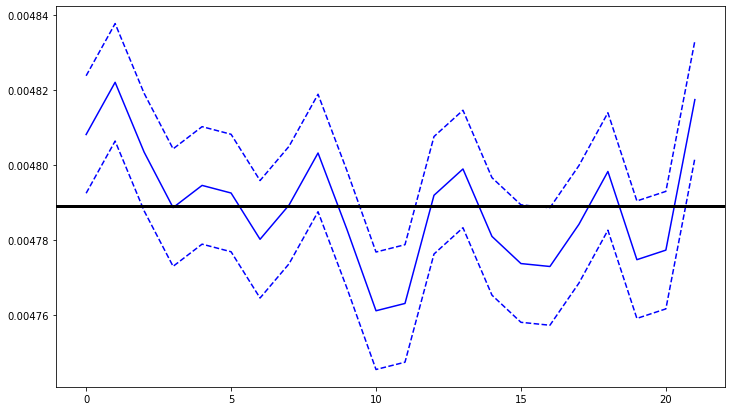

In [52]:
fig, ax = plt.subplots(figsize=(12,7))
for i,c in [[0,'blue']]:
    ax.plot(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i]),color=c)
    ax.plot(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])+np.std(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
    ax.plot(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])-np.std(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[i])),color=c, ls='--')
ax.axhline(np.mean(uncert_gdf.iloc[:22].lw_spectra_float.map(lambda x: x[0])), color='black', lw=3)
# ax.set_ylim(0.004,0.0055)
# ax.set_ylim(0.000,0.002)

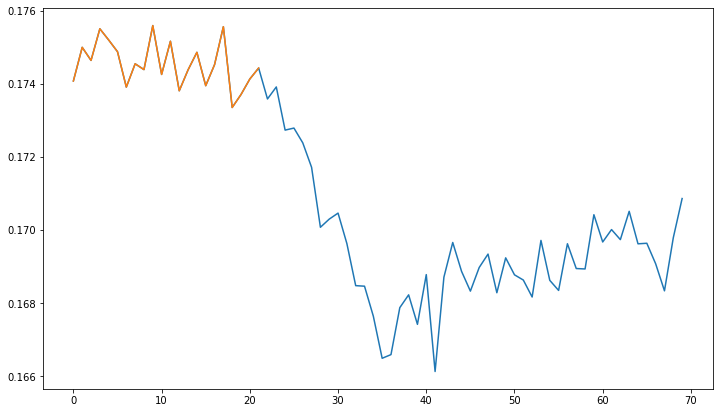

In [47]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(uncert_gdf.chla)
ax.plot(uncert_gdf.iloc[:22].chla)

In [8]:
np.array(uncert_gdf.lw_spectra_float)

array([array([0.00480806, 0.0015061 , 0.00018708, 0.00012701, 0.00013392]),
       array([0.00482198, 0.00152671, 0.00018818, 0.00012089, 0.00014066]),
       array([0.00480338, 0.00150561, 0.00017476, 0.00011602, 0.00013623]),
       array([0.00478857, 0.00150663, 0.00017126, 0.00010846, 0.00012719]),
       array([0.00479449, 0.00151034, 0.00018144, 0.00013606, 0.00013217]),
       array([0.00479246, 0.00150156, 0.00017307, 0.0001103 , 0.00013292]),
       array([0.00478012, 0.00148576, 0.00018296, 0.00016073, 0.00013457]),
       array([0.00478925, 0.00149823, 0.00018003, 0.00011325, 0.00013113]),
       array([0.00480313, 0.00150523, 0.00018217, 0.00011528, 0.00013363]),
       array([0.0047827 , 0.00150602, 0.00017543, 0.0001024 , 0.00013277]),
       array([0.00476106, 0.00147482, 0.00017269, 0.00013791, 0.0001307 ]),
       array([0.00476301, 0.00148832, 0.00017408, 0.00014192, 0.00013114]),
       array([0.00479185, 0.0014912 , 0.00018257, 0.00014254, 0.00013745]),
       array

(array([33., 10., 79., 93.,  3.,  2.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  0.,  2.,  1.,  5.]),
 array([0.15279598, 0.15911271, 0.16542945, 0.17174619, 0.17806293,
        0.18437967, 0.19069641, 0.19701314, 0.20332988, 0.20964662,
        0.21596336, 0.2222801 , 0.22859684, 0.23491357, 0.24123031,
        0.24754705, 0.25386379, 0.26018053, 0.26649727, 0.272814  ,
        0.27913074]),
 <BarContainer object of 20 artists>)

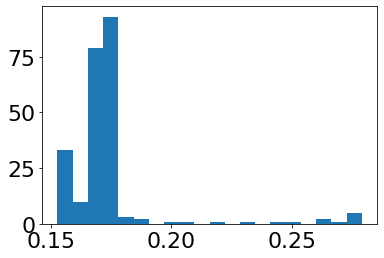

In [380]:
plt.hist(gdf0.chla,bins=20)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


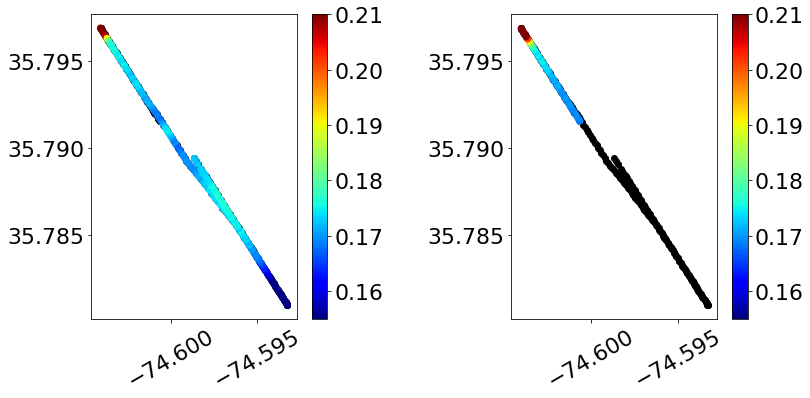

In [405]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
gdf0.plot('chla',ax=ax[0],vmin=0.155, vmax=.21, color='black', legend=True)
gdf0.plot('chla',ax=ax[1],vmin=0.155, vmax=.21, color='black', legend=True)


gdf0.iloc[50:].plot('chla',ax=ax[0],vmin=0.155, vmax=.21, cmap='jet', legend=True)
gdf0.iloc[:50].plot('chla',ax=ax[1],vmin=0.155, vmax=.21, cmap='jet', legend=True)


ax[0].tick_params(axis='x', rotation=30)
# ax.ticklabel_format(style='plain')
ax[0].ticklabel_format(useOffset=False, style='plain')

ax[1].tick_params(axis='x', rotation=30)
# ax.ticklabel_format(style='plain')
ax[1].ticklabel_format(useOffset=False, style='plain')

fig.tight_layout()

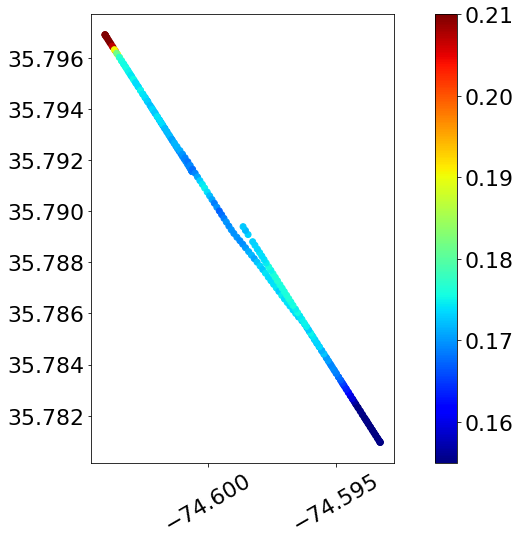

In [411]:
fig, ax = plt.subplots(figsize=(12,8))
gdf0.iloc[:].plot('chla',ax=ax,vmin=0.155, vmax=.21, cmap='jet', legend=True)

ax.tick_params(axis='x', rotation=30)
# ax.ticklabel_format(style='plain')
ax.ticklabel_format(useOffset=False, style='plain')

fig.tight_layout()
fig.savefig('gdf0_chla.png',dpi=300)

(array([ 32., 116., 106.,  44.,  13.,  12.,   5.,  25.,  39.,  15.]),
 array([0.11957445, 0.12515828, 0.1307421 , 0.13632593, 0.14190975,
        0.14749358, 0.1530774 , 0.15866123, 0.16424505, 0.16982887,
        0.1754127 ]),
 <BarContainer object of 10 artists>)

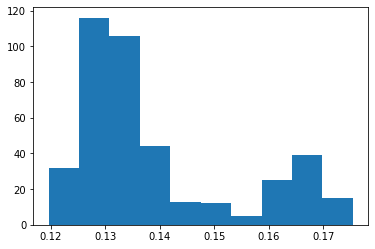

In [9]:
plt.hist(gdf1.chla)

<AxesSubplot:>

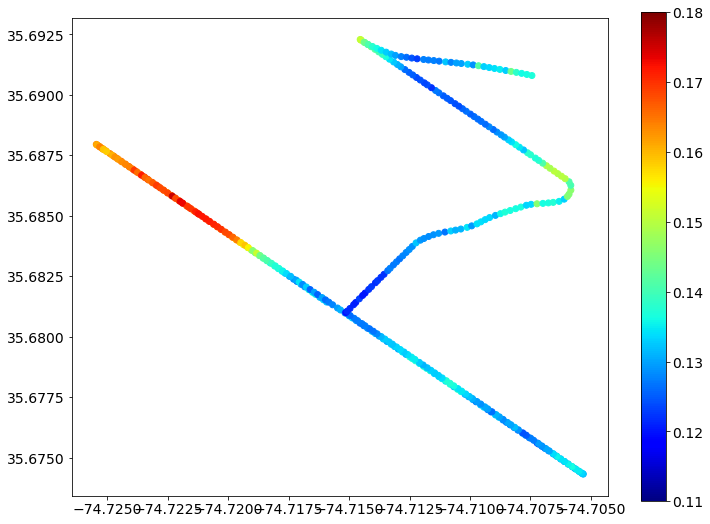

In [98]:
fig, ax = plt.subplots(figsize=(12,9))
# gdf1.iloc[:].plot('chla',ax=ax,vmin=0.11, vmax=.18, color='black', legend=True)
gdf1.iloc[:].plot('chla',ax=ax,vmin=0.11, vmax=.18, cmap='jet', alpha=1, legend=True)
# fig.savefig('gdf1_chla.png',dpi=300)

(array([ 16.,  11., 107., 104.,  29.,  25.,  15.,   3.,   1.,   2.]),
 array([0.16329076, 0.1663642 , 0.16943764, 0.17251107, 0.17558451,
        0.17865795, 0.18173139, 0.18480483, 0.18787826, 0.1909517 ,
        0.19402514]),
 <BarContainer object of 10 artists>)

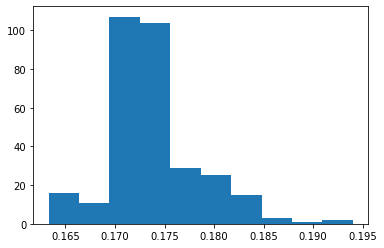

In [11]:
plt.hist(gdf2.chla)

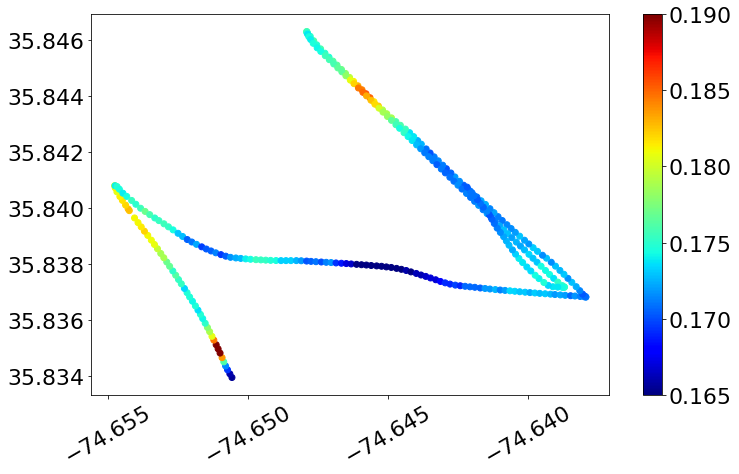

In [296]:
fig, ax = plt.subplots(figsize=(12,7))
gdf2.plot('chla',ax=ax,vmin=0.165, vmax=.19, cmap='jet', legend=True)
ax.tick_params(axis='x', rotation=30)
# ax.ticklabel_format(style='plain')
ax.ticklabel_format(useOffset=False, style='plain')

(array([24., 60., 51., 16.,  2.,  5.,  9., 10., 10.,  1.]),
 array([0.18932795, 0.19353786, 0.19774776, 0.20195767, 0.20616757,
        0.21037748, 0.21458738, 0.21879729, 0.22300719, 0.2272171 ,
        0.231427  ]),
 <BarContainer object of 10 artists>)

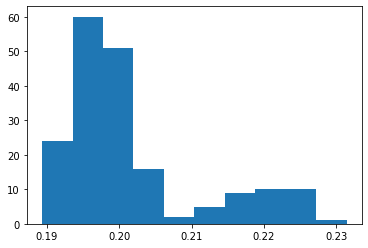

In [13]:
plt.hist(gdf3.chla)

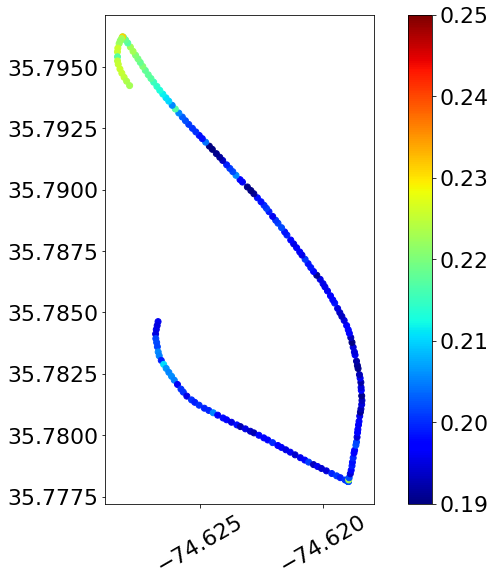

In [293]:
fig, ax = plt.subplots(figsize=(12,9))
gdf3.plot('chla',ax=ax,vmin=0.19, vmax=.25, cmap='jet', legend=True)
ax.tick_params(axis='x', rotation=30)
# ax.ticklabel_format(style='plain')
ax.ticklabel_format(useOffset=False, style='plain')

### Comparing to TriOS Data

In [99]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

In [101]:
ship_df = pd.read_csv('../gs_front_analysis_linux/data/ivan_data/tsg_gps/Navigation/SW-GGA_20210825-082425.Raw', index_col=None,
                 names=['date', 'time','spacer', 'idk', 'SW-GGA-Lat','latdir', 'SW-GGA-Long', 'londir', 'a','b','c','d','e','f','g'])

date_time_strs = ship_df['date'] + ' ' + ship_df['time']

ship_df['datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
# this was four minutes behind but with update to ship it is no longer
ship_df['utc_dt'] = ship_df['datetime']#+ timedelta(minutes=4)
ship_df  = ship_df.set_index('utc_dt')

ship_df['lon'] = dms2dd(pd.to_numeric(ship_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(ship_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
ship_df['lat'] = dms2dd(pd.to_numeric(ship_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(ship_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')


ship_gdf = gpd.GeoDataFrame(
    ship_df, geometry=gpd.points_from_xy(ship_df.lon, ship_df.lat))

In [102]:
ship_gdf.head()

date          time  spacer       idk  \
utc_dt                                                                
2021-08-25 08:24:30.412  08/25/2021  08:24:30.412  $GPGGA  82741.69   
2021-08-25 08:24:31.506  08/25/2021  08:24:31.506  $GPGGA  82742.69   
2021-08-25 08:24:32.287  08/25/2021  08:24:32.287  $GPGGA  82743.70   
2021-08-25 08:24:33.709  08/25/2021  08:24:33.709  $GPGGA  82744.70   
2021-08-25 08:24:34.631  08/25/2021  08:24:34.631  $GPGGA  82745.70   

                         SW-GGA-Lat latdir  SW-GGA-Long londir  a   b    c  \
utc_dt                                                                       
2021-08-25 08:24:30.412   3443.0547      N    7640.2343      W  2  29  0.5   
2021-08-25 08:24:31.506   3443.0547      N    7640.2343      W  2  29  0.5   
2021-08-25 08:24:32.287   3443.0547      N    7640.2343      W  2  29  0.5   
2021-08-25 08:24:33.709   3443.0547      N    7640.2342      W  2  29  0.5   
2021-08-25 08:24:34.631   3443.0547      N    7640.2342      W  2  28  0.5   

                            d  e     f     g                datetime  \
utc_dt                                                                 
2021-08-25 08:24:30.412 -28.5  M -36.8  M*43 2021-08-25 08:24:30.412   
2021-08-25 08:24:31.506 -28.5  M -36.8  M*40 2021-08-25 08:24:31.506   
2021-08-25 08:24:32.287 -28.5  M -36.8  M*79 2021-08-25 08:24:32.287   
2021-08-25 08:24:33.709 -28.5  M -36.8  M*7F 2021-08-25 08:24:33.709   
2021-08-25 08:24:34.631 -28.4  M -36.8  M*7E 2021-08-25 08:24:34.631   

                               lon        lat                    geometry  
utc_dt                                                                     
2021-08-25 08:24:30.412 -76.670572  34.717578  POINT (-76.67057 34.71758)  
2021-08-25 08:24:31.506 -76.670572  34.717578  POINT (-76.67057 34.71758)  
2021-08-25 08:24:32.287 -76.670572  34.717578  POINT (-76.67057 34.71758)  
2021-08-25 08:24:33.709 -76.670570  34.717578  POINT (-76.67057 34.71758)  
2021-08-25 08:24:34.631 -76.670570  34.717578  POINT (-76.67057 34.71758)

<AxesSubplot:>

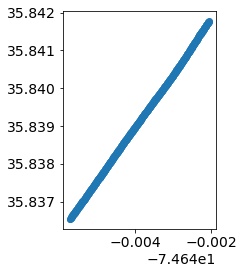

In [103]:
ship_gdf.loc['2021-08-27 19:12:27':'2021-08-27 19:22:47'].plot()

Pull in the trios data based on that day.

In [106]:
trios_fns = [
#     '../gs_front_analysis_linux/data/ivan_data/trios/shearwater_trios_20210826.csv',
    '../gs_front_analysis_linux/data/ivan_data/trios/shearwater_trios_20210827.csv',
#     '../gs_front_analysis_linux/data/ivan_data/trios/shearwater_trios_20210828.csv',

            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

Combine the Ship GPS with TriOS based on time

In [107]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['datetime'] = trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df['utc_dt'] =trios_df['datetime'] 
trios_df = trios_df.set_index('utc_dt')

In [108]:
lats = []
lons = []
for i in range(len(trios_df)):
    item = trios_df.iloc[i]
    img_idx = ship_gdf.index.get_loc(item['datetime'], method='nearest')
    lats.append(ship_gdf.iloc[img_idx]['lat'])
    lons.append(ship_gdf.iloc[img_idx]['lon'])

In [109]:
trios_df['lat'] = lats
trios_df['lon'] = lons

<AxesSubplot:>

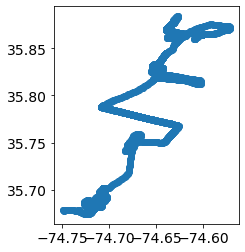

In [110]:
trios_gdf = gpd.GeoDataFrame(
    trios_df, geometry=gpd.points_from_xy(trios_df.lon, trios_df.lat))
trios_gdf.plot()

<AxesSubplot:>

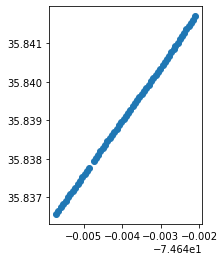

In [24]:
trios_gdf.loc['2021-08-27 19:12:27':'2021-08-27 19:22:47'].plot()

Trim the data to the flight time and closest locations.

In [111]:
trios_gdf_transect = trios_gdf#.loc[chla_gdf.iloc[0]['time']:chla_gdf.iloc[len(chla_gdf)-1]['time']]

In [112]:
from shapely.ops import nearest_points
# unary union of the gpd2 geomtries 
pts3 = trios_gdf_transect.geometry.unary_union

def near(point, pts=pts3):
    # find the nearest point and return the corresponding Place value
    nearest = trios_gdf_transect.geometry == nearest_points(point, pts)[1]
    return(trios_gdf_transect[nearest].lat.values[0])

gdf_all_flights['trios_lat'] = gdf_all_flights.apply(lambda row: near(row.geometry), axis=1)

def near(point, pts=pts3):
    # find the nearest point and return the corresponding Place value
    nearest = trios_gdf_transect.geometry == nearest_points(point, pts)[1]
    return(trios_gdf_transect[nearest].lon.values[0])

gdf_all_flights['trios_lon'] = gdf_all_flights.apply(lambda row: near(row.geometry), axis=1)
gdf_all_flights.head(2)

chla   Latitude  Longitude    sst  \
0  0.169086  35.791556 -74.600636  27.27   
1  0.166861  35.791556 -74.600636  27.24   

                                          lw_spectra             time_str  \
0  [4.88902001e-03 1.46889191e-03 1.40666728e-04 ...  2021-08-26 17:54:03   
1  [4.89128429e-03 1.43816144e-03 1.35672384e-04 ...  2021-08-26 17:54:05   

                     geometry   sst_c                time  flight  \
0  POINT (-74.60064 35.79156) -245.88 2021-08-26 17:54:03       3   
1  POINT (-74.60064 35.79156) -245.91 2021-08-26 17:54:05       3   

                                    lw_spectra_float  trios_lat  trios_lon  
0  [0.00488902001, 0.00146889191, 0.000140666728,...  35.811572 -74.604097  
1  [0.00489128429, 0.00143816144, 0.000135672384,...  35.811572 -74.604097

In [113]:
from shapely.ops import nearest_points
# unary union of the gpd2 geomtries 
pts3 = trios_gdf_transect.geometry.unary_union

def near(point, pts=pts3):
    # find the nearest point and return the corresponding Place value
    nearest = trios_gdf_transect.geometry == nearest_points(point, pts)[1]
    # need to index into columns by name
    return trios_gdf_transect[nearest][trios_gdf_transect.columns[1:-6]].values[0]

gdf_all_flights['trios_spec'] = gdf_all_flights.apply(lambda row: near(row.geometry), axis=1)
gdf_all_flights.head(2)

chla   Latitude  Longitude    sst  \
0  0.169086  35.791556 -74.600636  27.27   
1  0.166861  35.791556 -74.600636  27.24   

                                          lw_spectra             time_str  \
0  [4.88902001e-03 1.46889191e-03 1.40666728e-04 ...  2021-08-26 17:54:03   
1  [4.89128429e-03 1.43816144e-03 1.35672384e-04 ...  2021-08-26 17:54:05   

                     geometry   sst_c                time  flight  \
0  POINT (-74.60064 35.79156) -245.88 2021-08-26 17:54:03       3   
1  POINT (-74.60064 35.79156) -245.91 2021-08-26 17:54:05       3   

                                    lw_spectra_float  trios_lat  trios_lon  \
0  [0.00488902001, 0.00146889191, 0.000140666728,...  35.811572 -74.604097   
1  [0.00489128429, 0.00143816144, 0.000135672384,...  35.811572 -74.604097   

                                          trios_spec  
0  [0.0069607617, 0.0067700127, 0.006679830899999...  
1  [0.0069607617, 0.0067700127, 0.006679830899999...

In [114]:
trios_gdf_transect['chla_oci'] = oc_index(trios_gdf_transect.iloc[:, 156:161].mean(axis=1).values, trios_gdf_transect.iloc[:, 232:240].mean(axis=1).values, trios_gdf_transect.iloc[:, 346:351].mean(axis=1).values)

In [115]:
from shapely.ops import nearest_points
# unary union of the gpd2 geomtries 
pts3 = trios_gdf_transect.geometry.unary_union

def near(point, pts=pts3):
    # find the nearest point and return the corresponding Place value
    nearest = trios_gdf_transect.geometry == nearest_points(point, pts)[1]
    return trios_gdf_transect[nearest].chla_oci.values[0]

gdf_all_flights['trios_chla'] = gdf_all_flights.apply(lambda row: near(row.geometry), axis=1)
gdf_all_flights.head(2)

chla   Latitude  Longitude    sst  \
0  0.169086  35.791556 -74.600636  27.27   
1  0.166861  35.791556 -74.600636  27.24   

                                          lw_spectra             time_str  \
0  [4.88902001e-03 1.46889191e-03 1.40666728e-04 ...  2021-08-26 17:54:03   
1  [4.89128429e-03 1.43816144e-03 1.35672384e-04 ...  2021-08-26 17:54:05   

                     geometry   sst_c                time  flight  \
0  POINT (-74.60064 35.79156) -245.88 2021-08-26 17:54:03       3   
1  POINT (-74.60064 35.79156) -245.91 2021-08-26 17:54:05       3   

                                    lw_spectra_float  trios_lat  trios_lon  \
0  [0.00488902001, 0.00146889191, 0.000140666728,...  35.811572 -74.604097   
1  [0.00489128429, 0.00143816144, 0.000135672384,...  35.811572 -74.604097   

                                          trios_spec  trios_chla  
0  [0.0069607617, 0.0067700127, 0.006679830899999...    0.150112  
1  [0.0069607617, 0.0067700127, 0.006679830899999...    0.150112

In [116]:
from shapely.ops import nearest_points
# unary union of the gpd2 geomtries 
pts3 = trios_gdf_transect.geometry.unary_union

def near(point, pts=pts3):
    # find the nearest point and return the corresponding Place value
    nearest = trios_gdf_transect.geometry == nearest_points(point, pts)[1]
    return trios_gdf_transect[nearest].datetime.values[0]

gdf_all_flights['trios_datetime'] = gdf_all_flights.apply(lambda row: near(row.geometry), axis=1)
gdf_all_flights.head(2)

chla   Latitude  Longitude    sst  \
0  0.169086  35.791556 -74.600636  27.27   
1  0.166861  35.791556 -74.600636  27.24   

                                          lw_spectra             time_str  \
0  [4.88902001e-03 1.46889191e-03 1.40666728e-04 ...  2021-08-26 17:54:03   
1  [4.89128429e-03 1.43816144e-03 1.35672384e-04 ...  2021-08-26 17:54:05   

                     geometry   sst_c                time  flight  \
0  POINT (-74.60064 35.79156) -245.88 2021-08-26 17:54:03       3   
1  POINT (-74.60064 35.79156) -245.91 2021-08-26 17:54:05       3   

                                    lw_spectra_float  trios_lat  trios_lon  \
0  [0.00488902001, 0.00146889191, 0.000140666728,...  35.811572 -74.604097   
1  [0.00489128429, 0.00143816144, 0.000135672384,...  35.811572 -74.604097   

                                          trios_spec  trios_chla  \
0  [0.0069607617, 0.0067700127, 0.006679830899999...    0.150112   
1  [0.0069607617, 0.0067700127, 0.006679830899999...    0.150112   

       trios_datetime  
0 2021-08-27 18:08:20  
1 2021-08-27 18:08:20

In [117]:
import geopy.distance
def dist_fcn(sample_lat,sample_lon,uas_lat,uas_lon):
    coords_1 = (sample_lat, sample_lon)
    coords_2 = (uas_lat, uas_lon)
    return(geopy.distance.distance(coords_1, coords_2).km)
gdf_all_flights['pt_dist'] = gdf_all_flights.apply(lambda row: dist_fcn(row['Latitude'],row['Longitude'],row['trios_lat'],row['trios_lon']), axis=1)

(array([464., 194.,  62.,  42.,  67.,  71.,  87.,  63.,  42.,  50.]),
 array([1.42021631e-03, 3.54791190e-01, 7.08162163e-01, 1.06153314e+00,
        1.41490411e+00, 1.76827508e+00, 2.12164606e+00, 2.47501703e+00,
        2.82838800e+00, 3.18175898e+00, 3.53512995e+00]),
 <BarContainer object of 10 artists>)

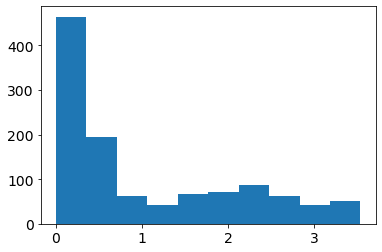

In [118]:
plt.hist(gdf_all_flights.pt_dist)

In [140]:
matched_subset = gdf_all_flights[gdf_all_flights.pt_dist < 0.05]
len(matched_subset)

108

In [148]:
matched_subset = matched_subset.iloc[:92]

In [149]:
duration = matched_subset.time - matched_subset.trios_datetime    # For build-in functions
duration_in_s = duration.dt.total_seconds()                         # Total number of seconds between dates

3000 seconds in hours

In [150]:
3000/60/24

2.0833333333333335

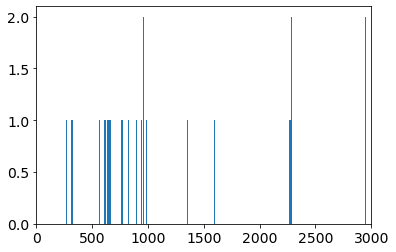

In [151]:
plt.hist(abs(duration_in_s),bins=1000)
plt.xlim(0,3000)
plt.show()

In [152]:
min(duration_in_s)/60/60

-0.8752777777777777

In [153]:
matched_subset['diff_in_sec'] = abs(duration_in_s.values)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In 8 minutes the water could be .72km away

In [154]:
4*1.5*60 

360.0

In [155]:
matched_subset = matched_subset[matched_subset.diff_in_sec < 60*30]
len(matched_subset)

61

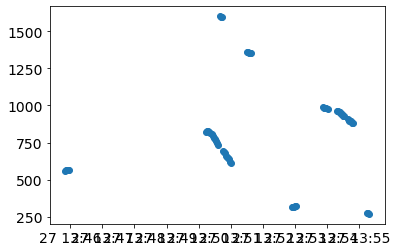

In [156]:
plt.scatter(matched_subset.time, matched_subset.diff_in_sec)

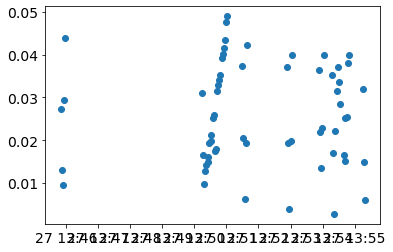

In [157]:
plt.scatter(matched_subset.time, matched_subset.pt_dist)

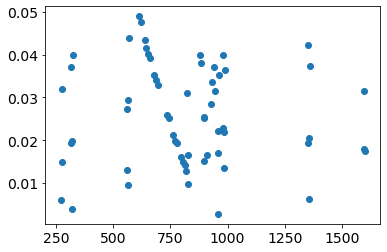

In [158]:
plt.scatter(matched_subset.diff_in_sec, matched_subset.pt_dist)

In [131]:
plt.rcParams.update({'font.size': 14})

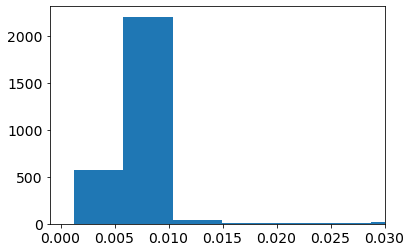

In [132]:
plt.hist(trios_gdf_transect['440'],bins=100)
plt.xlim(-0.001, 0.03)
plt.show()

(0.004, 0.0095)

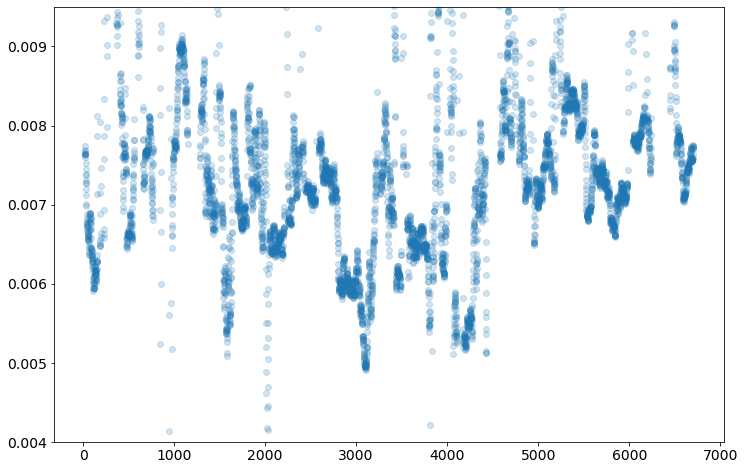

In [108]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(range(len(trios_gdf_transect)),trios_gdf_transect['440'].rolling(6*3).mean(), alpha=0.2)
ax.set_ylim(0.004, 0.0095)

In [109]:
matched_subset

chla   Latitude  Longitude    sst  \
86   0.172556  35.838125 -74.648264  26.81   
87   0.171904  35.838119 -74.648089  26.85   
88   0.170247  35.838108 -74.647897  26.85   
89   0.170534  35.838097 -74.647739  26.88   
90   0.170959  35.838086 -74.647564  26.86   
..        ...        ...        ...    ...   
308  0.170875  35.840167 -74.641694  26.71   
309  0.170382  35.840303 -74.641800  26.72   
310  0.171032  35.840444 -74.641919  26.73   
311  0.170970  35.840606 -74.642056  26.70   
312  0.170295  35.840747 -74.642167  26.72   

                                            lw_spectra             time_str  \
86   [4.87842448e-03 1.51017616e-03 1.44324926e-04 ...  2021-08-27 19:15:07   
87   [4.91854248e-03 1.53121392e-03 1.58830196e-04 ...  2021-08-27 19:15:09   
88   [4.92641518e-03 1.51230278e-03 1.54930477e-04 ...  2021-08-27 19:15:11   
89   [4.92850395e-03 1.51746851e-03 1.55241270e-04 ...  2021-08-27 19:15:13   
90   [4.94013527e-03 1.52981293e-03 1.54863607e-04 ...  2021-08-27 19:15:15   
..                                                 ...                  ...   
308  [4.67908023e-03 1.35071239e-03 9.61368235e-05 ...  2021-08-27 19:22:42   
309  [4.68053349e-03 1.34495580e-03 9.59777046e-05 ...  2021-08-27 19:22:44   
310  [4.66235579e-03 1.33742866e-03 8.27377274e-05 ...  2021-08-27 19:22:46   
311  [4.65089626e-03 1.32920202e-03 8.11337002e-05 ...  2021-08-27 19:22:48   
312  [4.65595452e-03 1.32409735e-03 8.32716261e-05 ...  2021-08-27 19:22:50   

                       geometry   sst_c                time  flight  \
86   POINT (-74.64826 35.83813) -246.34 2021-08-27 19:15:07       2   
87   POINT (-74.64809 35.83812) -246.30 2021-08-27 19:15:09       2   
88   POINT (-74.64790 35.83811) -246.30 2021-08-27 19:15:11       2   
89   POINT (-74.64774 35.83810) -246.27 2021-08-27 19:15:13       2   
90   POINT (-74.64756 35.83809) -246.29 2021-08-27 19:15:15       2   
..                          ...     ...                 ...     ...   
308  POINT (-74.64169 35.84017) -246.44 2021-08-27 19:22:42       2   
309  POINT (-74.64180 35.84030) -246.43 2021-08-27 19:22:44       2   
310  POINT (-74.64192 35.84044) -246.42 2021-08-27 19:22:46       2   
311  POINT (-74.64206 35.84061) -246.45 2021-08-27 19:22:48       2   
312  POINT (-74.64217 35.84075) -246.43 2021-08-27 19:22:50       2   

                                      lw_spectra_float  trios_lat  trios_lon  \
86   [0.00487842448, 0.00151017616, 0.000144324926,...  35.836482 -74.645775   
87   [0.00491854248, 0.00153121392, 0.000158830196,...  35.836482 -74.645775   
88   [0.00492641518, 0.00151230278, 0.000154930477,...  35.836482 -74.645775   
89   [0.00492850395, 0.00151746851, 0.00015524127, ...  35.836655 -74.645652   
90   [0.00494013527, 0.00152981293, 0.000154863607,...  35.836655 -74.645652   
..                                                 ...        ...        ...   
308  [0.00467908023, 0.00135071239, 9.61368235e-05,...  35.840848 -74.642655   
309  [0.00468053349, 0.0013449558, 9.59777046e-05, ...  35.840848 -74.642655   
310  [0.00466235579, 0.00133742866, 8.27377274e-05,...  35.840848 -74.642655   
311  [0.00465089626, 0.00132920202, 8.11337002e-05,...  35.841017 -74.642550   
312  [0.00465595452, 0.00132409735, 8.32716261e-05,...  35.841017 -74.642550   

                                            trios_spec  trios_chla  \
86   [0.0074788716, 0.0072707787, 0.0071801447, 0.0...    0.179246   
87   [0.0074788716, 0.0072707787, 0.0071801447, 0.0...    0.179246   
88   [0.0074788716, 0.0072707787, 0.0071801447, 0.0...    0.179246   
89   [0.0063350651000000004, 0.0061544424, 0.006074...    0.182599   
90   [0.0063350651000000004, 0.0061544424, 0.006074...    0.182599   
..                                                 ...         ...   
308  [0.0074499182, 0.0072342182, 0.0071289423, 0.0...    0.183719   
309  [0.0074499182, 0.0072342182, 0.0071289423, 0.0...    0.183719   
310  [0.0074499182, 0.0072342182, 0.0071289423, 0.0...    0.183

(0.0, 0.008)

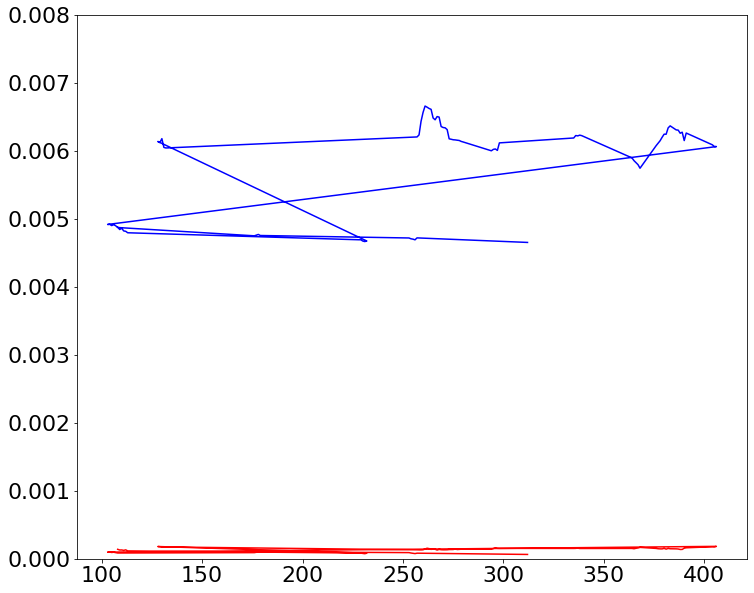

In [259]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(matched_subset.lw_spectra_float.map(lambda x: x[0]),color='blue')

ax.plot(matched_subset.lw_spectra_float.map(lambda x: x[4]),color='red')

ax.set_ylim(0,0.008)

(0.0, 0.008)

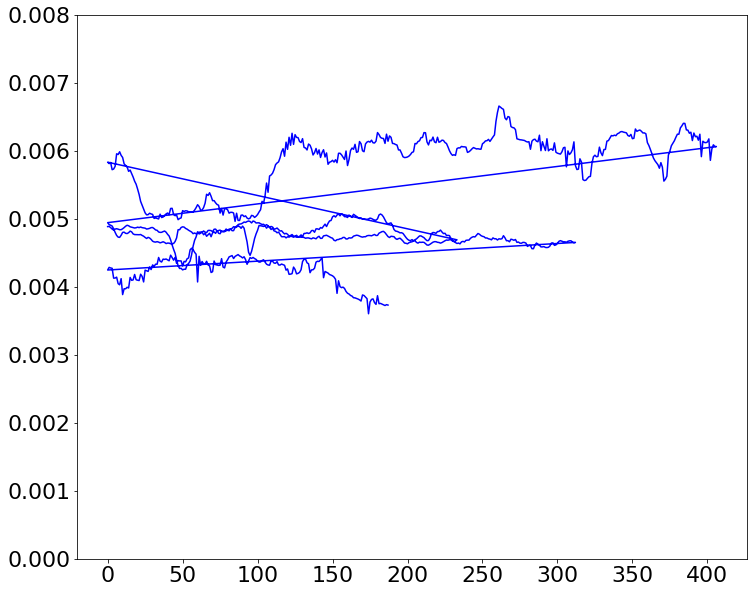

In [261]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(gdf_all_flights.lw_spectra_float.map(lambda x: x[0]),color='blue')

# ax.plot(gdf_all_flights.lw_spectra_float.map(lambda x: x[4]),color='red')

ax.set_ylim(0,0.008)

In [270]:
matched_subset.iloc[80].time

Timestamp('2021-08-27 19:18:16')

Text(0.5, 0, 'Wavelength (nm)')

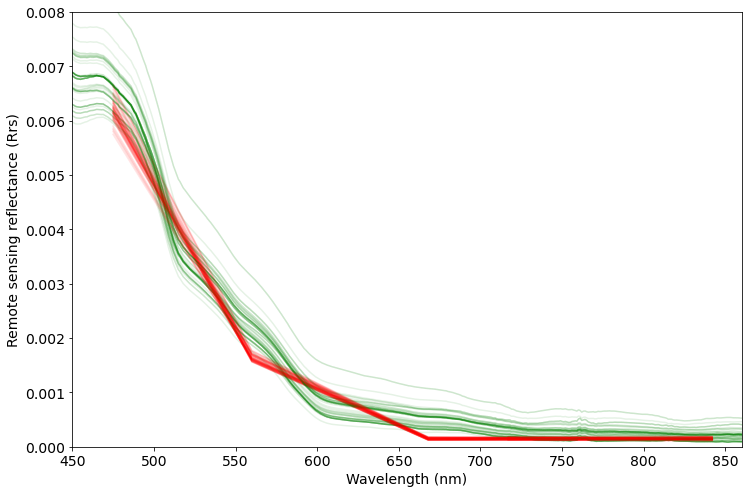

In [159]:
fig,ax = plt.subplots(figsize=(12,8))
for i in range(len(matched_subset)):
    ax.plot(trios_gdf_transect.columns[1:-7].astype(int),matched_subset.iloc[i].trios_spec, color='green', alpha=0.1)
    ax.plot([475, 560, 668, 842, 717],matched_subset.iloc[i].lw_spectra_float, color='red', alpha=0.1)
ax.set_xlim(450,860)
ax.set_ylim(0,0.008)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('comparing_trios_to_altum.png',dpi=300)

see if I can correct all the trios data down to ~0 in the red

In [185]:
trios_gdf_transect.columns[1:-7].astype(int)[-200:-150]

Int64Index([749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761,
            762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
            775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787,
            788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798],
           dtype='int64')

In [197]:
corrected_spec = []
for spec in matched_subset.trios_spec:
    nir_min = np.sort(spec[-100:])[:25]
    corrected_spec.append(spec - np.mean(nir_min))

In [180]:
np.min(spec[-50:])

-4.1789502991841296e-05

In [116]:
spec[-100:].mean()

0.000271469172

In [117]:
np.min(spec[-100:])

0.00016892669999999998

In [282]:
len(matched_subset)

88

Text(0.5, 0, 'Wavelength (nm)')

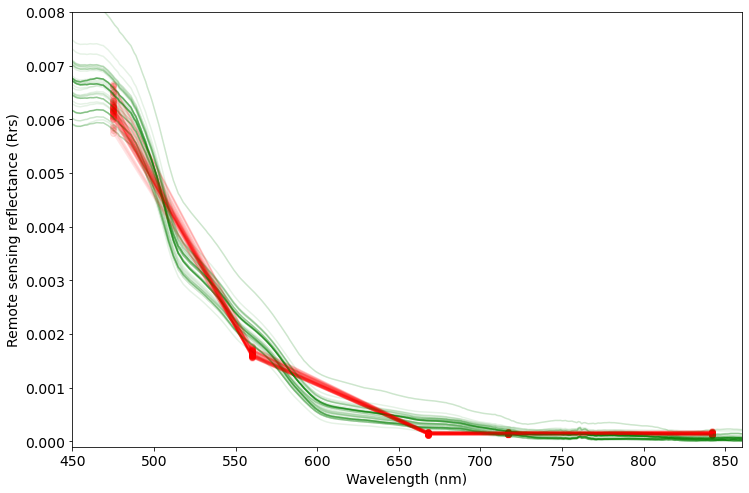

In [200]:
fig,ax = plt.subplots(figsize=(12,8))
for i in range(len(matched_subset)):
    ax.plot(trios_gdf_transect.columns[1:-7].astype(int),corrected_spec[i], color='green', alpha=0.1)
    ax.plot([475, 560, 668, 842, 717],matched_subset.iloc[i].lw_spectra_float, color='red', alpha=0.1)
    ax.scatter([475, 560, 668, 842, 717],matched_subset.iloc[i].lw_spectra_float, color='red', alpha=0.1)
ax.set_xlim(450,860)
ax.set_ylim(-0.0001,0.008)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('comparing_trios_to_altum.png',dpi=300)

Text(0.5, 0, 'Wavelength (nm)')

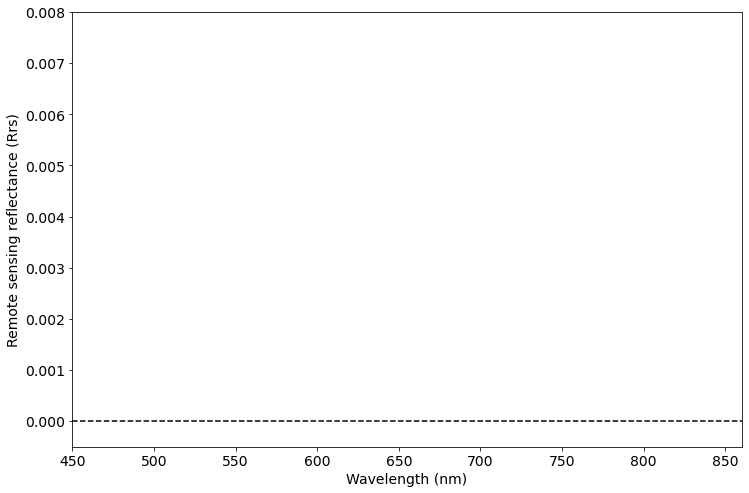

In [168]:
fig,ax = plt.subplots(figsize=(12,8))
for i in range(80,len(matched_subset)):
    ax.plot(trios_gdf_transect.columns[1:-7].astype(int),corrected_spec[i], color='green', alpha=0.1)
    ax.scatter([475, 560, 668, 842, 717],matched_subset.iloc[i].lw_spectra_float, color='red', alpha=0.1)
    
ax.axhline(0.0, color='black', ls='--')
ax.set_xlim(450,860)
ax.set_ylim(-0.0005,0.008)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('comparing_trios_to_altum.png',dpi=300)

In [121]:
matched_subset['corrected_trios'] = corrected_spec

(0.0, 0.001)

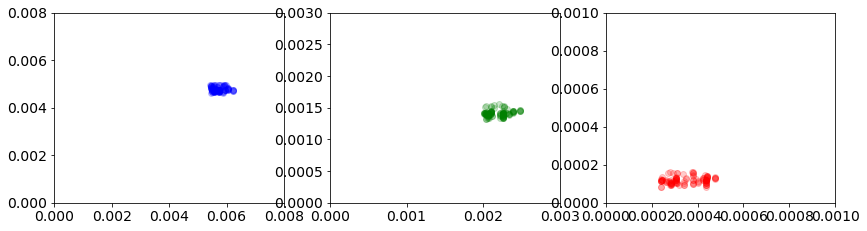

In [122]:
fig,ax = plt.subplots(1,3, figsize=(14,3.5))
for i in range(len(matched_subset)):
    ax[0].scatter(matched_subset.iloc[i].corrected_trios[156:161].mean(),matched_subset.iloc[i].lw_spectra_float[0], color='blue', alpha=0.2)
    ax[1].scatter(matched_subset.iloc[i].corrected_trios[232:240].mean(),matched_subset.iloc[i].lw_spectra_float[1], color='green', alpha=0.2)
    ax[2].scatter(matched_subset.iloc[i].corrected_trios[346:351].mean(),matched_subset.iloc[i].lw_spectra_float[2], color='red', alpha=0.2)
#     ax.plot(matched_subset.columns[1:-11].astype(int),matched_subset.iloc[i,1:-11], color='green', alpha=0.3)
#     ax.plot([475, 560, 668, 717, 842],matched_subset.iloc[i].uas_spec, color='red', alpha=0.2)
ax[0].set_xlim(0.000,0.008)
ax[0].set_ylim(0.000,0.008)

ax[1].set_xlim(0.000,0.003)
ax[1].set_ylim(0.000,0.003)

ax[2].set_xlim(0.000,0.001)
ax[2].set_ylim(0.000,0.001)
# ax.set_ylabel('Remote sensing reflectance (Rrs)')
# ax.set_xlabel('Wavelength (nm)')
# fig.savefig('comparing_trios_spectra_to_altum.png',dpi=300)

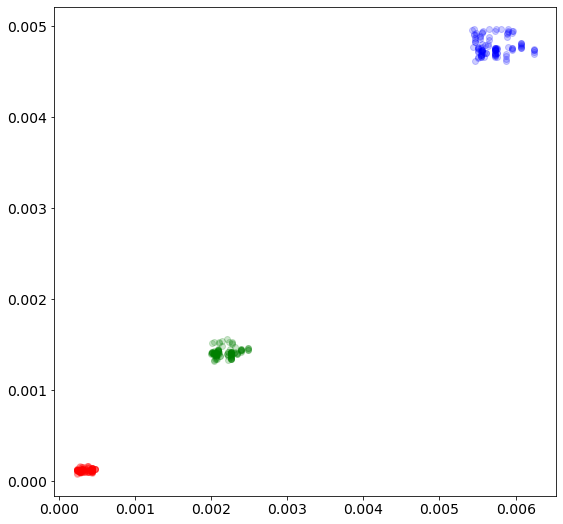

In [123]:
fig,ax = plt.subplots(figsize=(9,9))
for i in range(len(matched_subset)):
    ax.scatter(matched_subset.iloc[i].corrected_trios[156:161].mean(),matched_subset.iloc[i].lw_spectra_float[0], color='blue', alpha=0.2)
    ax.scatter(matched_subset.iloc[i].corrected_trios[232:240].mean(),matched_subset.iloc[i].lw_spectra_float[1], color='green', alpha=0.2)
    ax.scatter(matched_subset.iloc[i].corrected_trios[346:351].mean(),matched_subset.iloc[i].lw_spectra_float[2], color='red', alpha=0.2)
#     ax.plot(matched_subset.columns[1:-11].astype(int),matched_subset.iloc[i,1:-11], color='green', alpha=0.3)
#     ax.plot([475, 560, 668, 717, 842],matched_subset.iloc[i].uas_spec, color='red', alpha=0.2)
# ax[0].set_xlim(0.000,0.008)
# ax[0].set_ylim(0.000,0.008)

# ax[1].set_xlim(0.000,0.003)
# ax[1].set_ylim(0.000,0.003)

# ax[2].set_xlim(0.000,0.001)
# ax[2].set_ylim(0.000,0.001)
# ax.set_ylabel('Remote sensing reflectance (Rrs)')
# ax.set_xlabel('Wavelength (nm)')
# fig.savefig('comparing_trios_spectra_to_altum.png',dpi=300)

In [124]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(matched_subset.trios_chla, matched_subset.chla)

In [125]:
slope, intercept, r_value, p_value, std_err 

(0.0818230496789979,
 0.15567837505180365,
 0.0628937281617365,
 0.5061916883306093,
 0.12268703085054251)

In [126]:
r_value**2

0.0039556210420824064

Text(0, 0.5, 'UAS Chla mg/m3')

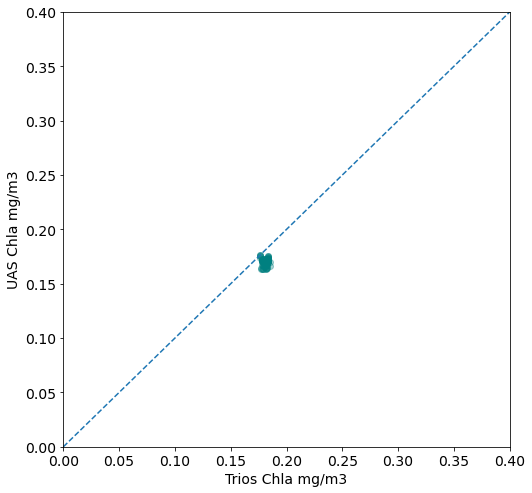

In [127]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(matched_subset.trios_chla, matched_subset.chla, alpha=0.35, color='teal')
ax.plot([0,1], [0,1], ls='--')
ax.set_xlim(.0,.4)
ax.set_ylim(.0,.4)
ax.set_xlabel('Trios Chla mg/m3')
ax.set_ylabel('UAS Chla mg/m3')
# fig.savefig('comparing_trios_uas_chla.png')

Do some comparisons

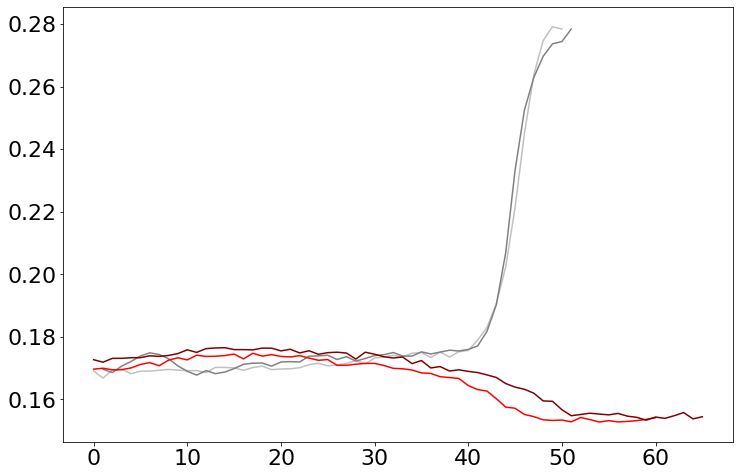

In [309]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,51,1), gdf0.iloc[:51].chla, color='silver')
ax.plot(np.arange(51,0,-1), gdf0.iloc[50:101].chla, color='grey')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.plot(np.arange(0,61,1), gdf0.iloc[107:168].chla, color='red')
ax.plot(np.arange(65,-1,-1), gdf0.iloc[168:].chla, color='maroon')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

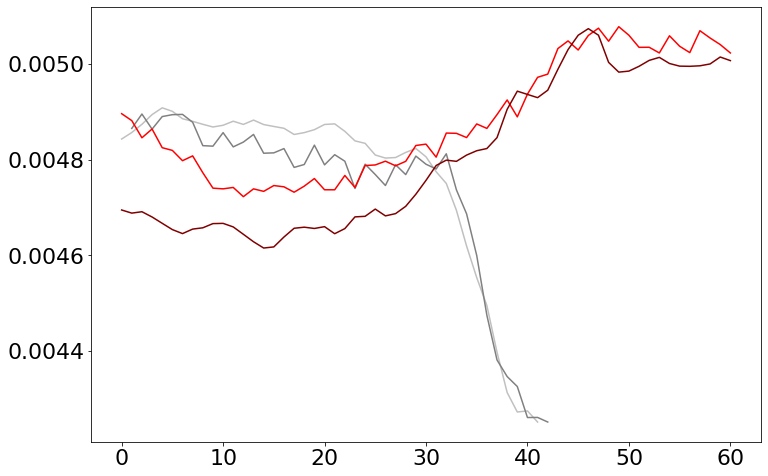

In [315]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,51-9,1), gdf0.iloc[9:51].lw_spectra_float.map(lambda x: x[0]), color='silver')
ax.plot(np.arange(51-9,0,-1), gdf0.iloc[50:101-9].lw_spectra_float.map(lambda x: x[0]), color='grey')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.plot(np.arange(0,61,1), gdf0.iloc[107:168].lw_spectra_float.map(lambda x: x[0]), color='red')
ax.plot(np.arange(65-5,-1,-1), gdf0.iloc[168:-5].lw_spectra_float.map(lambda x: x[0]), color='maroon')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

In [332]:
plt.rcParams.update({'font.size': 15})

In [211]:
float(np.std(uncert_gdf.iloc[:].lw_spectra_float.map(lambda x: x[i])))

1.1312350851544899e-05

In [ ]:
0.000072

array([0.00425195, 0.00427523, 0.0042729 , 0.0043136 , 0.00439788,
       0.0044954 , 0.00455381, 0.00461974, 0.00469434, 0.00475055,
       0.00477509, 0.00480621, 0.00482361, 0.00481537, 0.00480472,
       0.00480362, 0.00481   , 0.00483437, 0.00483953, 0.00485948,
       0.00487507, 0.00487381, 0.00486296, 0.00485677, 0.00485291,
       0.00486586, 0.00486964, 0.00487364, 0.00488296, 0.00487392,
       0.00488062, 0.00487216, 0.00486854, 0.00487421, 0.00488033,
       0.00488581, 0.00490129, 0.00490861, 0.00489444, 0.00487419,
       0.00485698, 0.00484339])

In [230]:
stds_list

[7.183649882211773e-05,
 1.4519771838460445e-05,
 1.1312350851544899e-05,
 2.40048282267275e-05,
 1.047908321739266e-05]

In [14]:
import sys
sys.getsizeof(np.int8(123))

25

In [15]:
sys.getsizeof(np.float32(123))

28

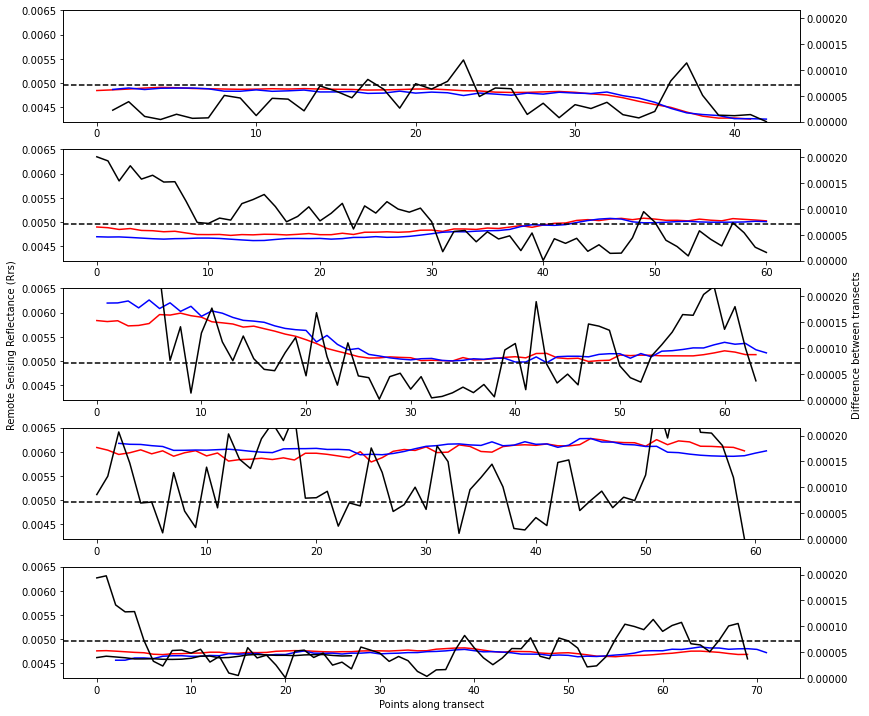

In [27]:
fig, ax = plt.subplots(5, figsize=(12,10))

ax[0].plot(np.arange(0,51-9,1), gdf0.iloc[9:51].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[0].plot(np.arange(51-9,0,-1), gdf0.iloc[50:101-9].lw_spectra_float.map(lambda x: x[0]), color='blue')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax1 = ax[0].twinx()
ax1.plot(np.arange(51-9,0,-1), abs(gdf0.iloc[50:101-9].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf0.iloc[9:51].lw_spectra_float.map(lambda x: x[0]).values)), color='black')
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')
ax1.set_ylim(0,stds_list[0]*3)
# ax1.plot(np.arange(0,51-9,1), gdf0.iloc[9:51].chla, color='red', ls='--')
# ax1.plot(np.arange(51-9,0,-1), gdf0.iloc[50:101-9].chla, color='blue', ls='--')

ax[1].plot(np.arange(0,61,1), gdf0.iloc[107:168].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[1].plot(np.arange(65-5,-1,-1), gdf0.iloc[168:-5].lw_spectra_float.map(lambda x: x[0]), color='blue')

ax1 = ax[1].twinx()
ax1.plot(np.arange(0,61,1), abs(gdf0.iloc[107:168].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf0.iloc[168:-5].lw_spectra_float.map(lambda x: x[0]).values)), color='black')
ax1.set_ylim(0,stds_list[0]*3)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')

# ax1.plot(np.arange(0,64,1), gdf1.iloc[0:64].chla, color='red', ls='--')
# ax1.plot(np.arange(64,0,-1), gdf1.iloc[64:128].chla, color='blue', ls='--')

ax[2].plot(np.arange(0,64,1), gdf1.iloc[0:64].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[2].plot(np.arange(64,0,-1), gdf1.iloc[64:128].lw_spectra_float.map(lambda x: x[0]), color='blue')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax1 = ax[2].twinx()
ax1.plot(np.arange(0,64,1), abs(gdf1.iloc[0:64].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf1.iloc[64:128].lw_spectra_float.map(lambda x: x[0]).values)), color='black')
ax1.set_ylim(0,stds_list[0]*3)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')
ax1.set_ylabel('Difference between transects')

ax[3].plot(np.arange(0,60,1), gdf1.iloc[135:195].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[3].plot(np.arange(61,1,-1), gdf1.iloc[195:255].lw_spectra_float.map(lambda x: x[0]), color='blue')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax1 = ax[3].twinx()
ax1.plot(np.arange(0,60,1), abs(gdf1.iloc[135:195].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf1.iloc[195:255].lw_spectra_float.map(lambda x: x[0]).values)), color='black')
ax1.set_ylim(0,stds_list[0]*3)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')

ax[4].plot(np.arange(0,70,1), gdf2.iloc[145:215].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[4].plot(np.arange(71,1,-1), gdf2.iloc[215:285].lw_spectra_float.map(lambda x: x[0]), color='blue')
ax[4].plot(np.arange(0,28,1), gdf2.iloc[285:].lw_spectra_float.map(lambda x: x[0]), color='black')

ax1 = ax[4].twinx()
ax1.plot(np.arange(0,70,1), abs(gdf2.iloc[145:215].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf2.iloc[215:285].lw_spectra_float.map(lambda x: x[0]).values)), color='black')
ax1.set_ylim(0,stds_list[0]*3)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')

ax[2].set_ylabel('Remote Sensing Reflectance (Rrs)')
ax[4].set_xlabel('Points along transect')

for i in range(5):
    ax[i].set_ylim(0.0042,0.0065)
fig.tight_layout()
fig.savefig('oc_analysis_blue_comparison_overlap_with_mismatch_uncert.png',dpi=300)

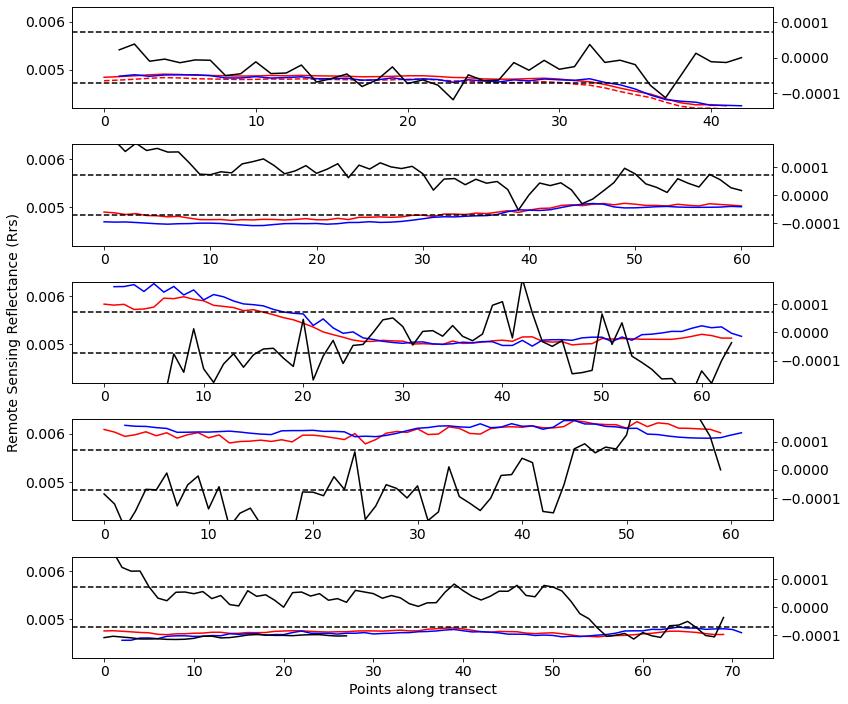

In [250]:
fig, ax = plt.subplots(5, figsize=(12,10))

ax[0].plot(np.arange(0,51-9,1), gdf0.iloc[9:51].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[0].plot(np.arange(0,51-9,1), gdf0.iloc[9:51].lw_spectra_float.map(lambda x: x[0])-stds_list[0], color='red',ls='--')
ax[0].plot(np.arange(51-9,0,-1), gdf0.iloc[50:101-9].lw_spectra_float.map(lambda x: x[0]), color='blue')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')
ax1 = ax[0].twinx()
ax1.plot(np.arange(51-9,0,-1), gdf0.iloc[50:101-9].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf0.iloc[9:51].lw_spectra_float.map(lambda x: x[0]).values), color='black')
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')
ax1.set_ylim(-stds_list[0]*2,stds_list[0]*2)
# ax1.plot(np.arange(0,51-9,1), gdf0.iloc[9:51].chla, color='red', ls='--')
# ax1.plot(np.arange(51-9,0,-1), gdf0.iloc[50:101-9].chla, color='blue', ls='--')

ax[1].plot(np.arange(0,61,1), gdf0.iloc[107:168].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[1].plot(np.arange(65-5,-1,-1), gdf0.iloc[168:-5].lw_spectra_float.map(lambda x: x[0]), color='blue')

ax1 = ax[1].twinx()
ax1.plot(np.arange(0,61,1), gdf0.iloc[107:168].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf0.iloc[168:-5].lw_spectra_float.map(lambda x: x[0]).values), color='black')
ax1.set_ylim(-stds_list[0]*2.5,stds_list[0]*2.5)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')

# ax1.plot(np.arange(0,64,1), gdf1.iloc[0:64].chla, color='red', ls='--')
# ax1.plot(np.arange(64,0,-1), gdf1.iloc[64:128].chla, color='blue', ls='--')

ax[2].plot(np.arange(0,64,1), gdf1.iloc[0:64].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[2].plot(np.arange(64,0,-1), gdf1.iloc[64:128].lw_spectra_float.map(lambda x: x[0]), color='blue')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax1 = ax[2].twinx()
ax1.plot(np.arange(0,64,1), gdf1.iloc[0:64].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf1.iloc[64:128].lw_spectra_float.map(lambda x: x[0]).values), color='black')
ax1.set_ylim(-stds_list[0]*2.5,stds_list[0]*2.5)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')

ax[3].plot(np.arange(0,60,1), gdf1.iloc[135:195].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[3].plot(np.arange(61,1,-1), gdf1.iloc[195:255].lw_spectra_float.map(lambda x: x[0]), color='blue')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax1 = ax[3].twinx()
ax1.plot(np.arange(0,60,1), gdf1.iloc[135:195].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf1.iloc[195:255].lw_spectra_float.map(lambda x: x[0]).values), color='black')
ax1.set_ylim(-stds_list[0]*2.5,stds_list[0]*2.5)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')

ax[4].plot(np.arange(0,70,1), gdf2.iloc[145:215].lw_spectra_float.map(lambda x: x[0]), color='red')
ax[4].plot(np.arange(71,1,-1), gdf2.iloc[215:285].lw_spectra_float.map(lambda x: x[0]), color='blue')
ax[4].plot(np.arange(0,28,1), gdf2.iloc[285:].lw_spectra_float.map(lambda x: x[0]), color='black')

ax1 = ax[4].twinx()
ax1.plot(np.arange(0,70,1), gdf2.iloc[145:215].lw_spectra_float.map(lambda x: x[0]).values-np.flip(gdf2.iloc[215:285].lw_spectra_float.map(lambda x: x[0]).values), color='black')
ax1.set_ylim(-stds_list[0]*2.5,stds_list[0]*2.5)
ax1.axhline(stds_list[0],color='black', ls='--')
ax1.axhline(stds_list[0]*-1, color='black',ls='--')

ax[2].set_ylabel('Remote Sensing Reflectance (Rrs)')
ax[4].set_xlabel('Points along transect')

for i in range(5):
    ax[i].set_ylim(0.0042,0.0063)
fig.tight_layout()
# fig.savefig('oc_analysis_blue_comparison_overlap_with_mismatch_uncert.png',dpi=300)

Text(0.5, 0, 'Points along transect')

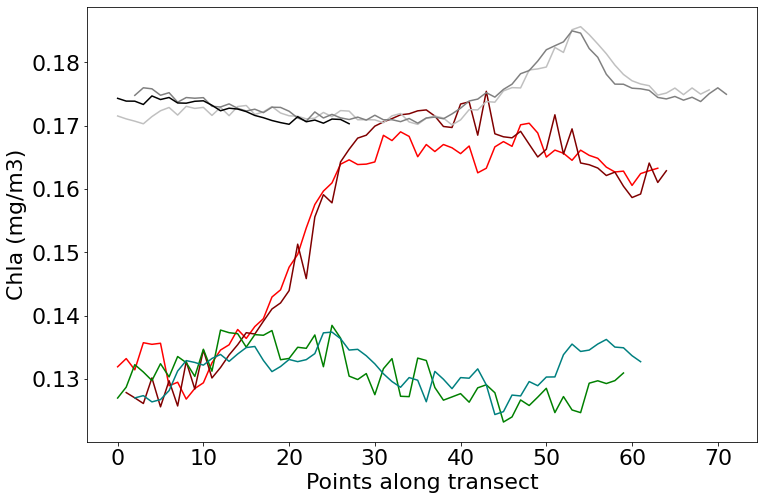

In [305]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,64,1), gdf1.iloc[0:64].chla, color='red')
ax.plot(np.arange(64,0,-1), gdf1.iloc[64:128].chla, color='maroon')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.plot(np.arange(0,60,1), gdf1.iloc[135:195].chla, color='green')
ax.plot(np.arange(61,1,-1), gdf1.iloc[195:255].chla, color='teal')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

# ax.set_ylim(0.235,0.276)

ax.plot(np.arange(0,70,1), gdf2.iloc[145:215].chla, color='silver')
ax.plot(np.arange(71,1,-1), gdf2.iloc[215:285].chla, color='grey')
ax.plot(np.arange(0,28,1), gdf2.iloc[285:].chla, color='black')

ax.set_ylabel('Chla (mg/m3)')
ax.set_xlabel('Points along transect')
# fig.savefig('oc_analysis_20210827_A1_gulf_stream_surveys_chla_comparison_overlap.png')

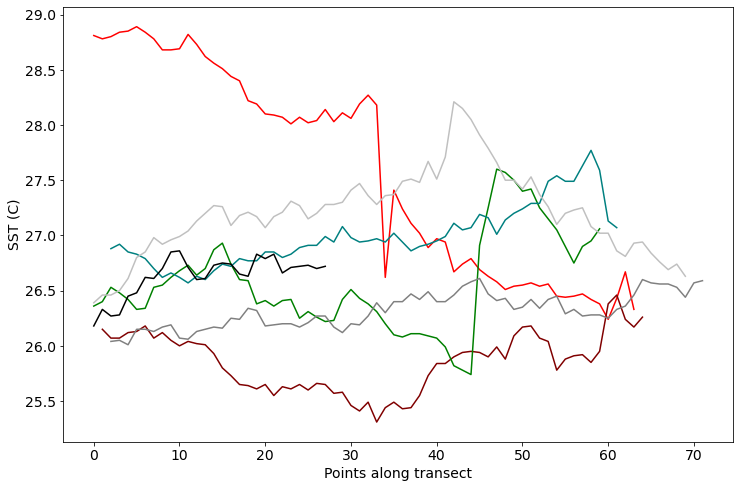

In [275]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,64,1), gdf1.iloc[0:64].sst, color='red')
ax.plot(np.arange(64,0,-1), gdf1.iloc[64:128].sst, color='maroon')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.plot(np.arange(0,60,1), gdf1.iloc[135:195].sst, color='green')
ax.plot(np.arange(61,1,-1), gdf1.iloc[195:255].sst, color='teal')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

# ax.set_ylim(0.235,0.276)

ax.plot(np.arange(0,70,1), gdf2.iloc[145:215].sst, color='silver')
ax.plot(np.arange(71,1,-1), gdf2.iloc[215:285].sst, color='grey')
ax.plot(np.arange(0,28,1), gdf2.iloc[285:].sst, color='black')

ax.set_ylabel('SST (C)')
ax.set_xlabel('Points along transect')
fig.savefig('oc_analysis_20210827_A1_gulf_stream_surveys_sst_comparison_overlap.png')

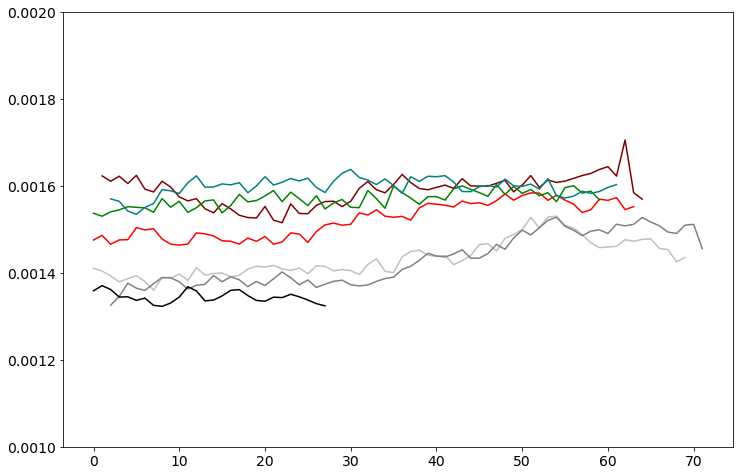

In [110]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,64,1), gdf1.iloc[0:64].green, color='red')
ax.plot(np.arange(64,0,-1), gdf1.iloc[64:128].green, color='maroon')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.plot(np.arange(0,60,1), gdf1.iloc[135:195].green, color='green')
ax.plot(np.arange(61,1,-1), gdf1.iloc[195:255].green, color='teal')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.set_ylim(0.001,0.002)

ax.plot(np.arange(0,70,1), gdf2.iloc[145:215].green, color='silver')
ax.plot(np.arange(71,1,-1), gdf2.iloc[215:285].green, color='grey')
ax.plot(np.arange(0,28,1), gdf2.iloc[285:].green, color='black')

# fig.savefig('oc_analysis_20210827_A1_gulf_stream_surveys_comparison_overlap.png')

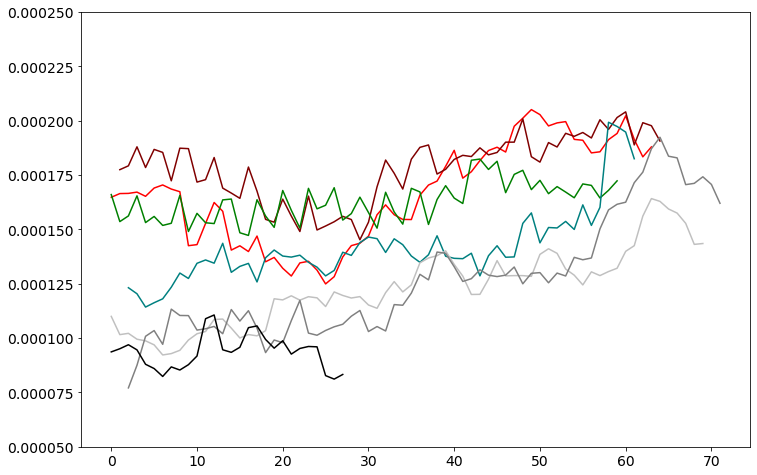

In [113]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,64,1), gdf1.iloc[0:64].red, color='red')
ax.plot(np.arange(64,0,-1), gdf1.iloc[64:128].red, color='maroon')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.plot(np.arange(0,60,1), gdf1.iloc[135:195].red, color='green')
ax.plot(np.arange(61,1,-1), gdf1.iloc[195:255].red, color='teal')
# ax.plot(np.arange(0,28,1), chla_gdf.iloc[285:].chla, color='black')

ax.set_ylim(0.00005,0.00025)

ax.plot(np.arange(0,70,1), gdf2.iloc[145:215].red, color='silver')
ax.plot(np.arange(71,1,-1), gdf2.iloc[215:285].red, color='grey')
ax.plot(np.arange(0,28,1), gdf2.iloc[285:].red, color='black')

# fig.savefig('oc_analysis_20210827_A1_gulf_stream_surveys_comparison_overlap.png')

In [118]:
mgdf_copy = matched_subset.copy()
mgdf_copy['time_str'] = mgdf_copy['time'].astype(str)
mgdf_copy['trios_datetime_str'] = mgdf_copy['trios_datetime'].astype(str)
mgdf_copy['lw_spectra_float'] = mgdf_copy['lw_spectra_float'].astype(str)
mgdf_copy['trios_spec'] = mgdf_copy['trios_spec'].astype(str)
mgdf_copy['corrected_trios'] = mgdf_copy['corrected_trios'].astype(str)
mgdf_copy.drop('time', 1).drop('trios_datetime', 1).to_file('data/matched_trios_uas_gulf_stream_surveys.shp')

### Sat Data

In [7]:
! ls data/*nc

data/SEAHAWK1_HAWKEYE.20210909T152714.L2.OC.nc
data/V2021239182400.L2_SNPP_OC.nc
data/V2021240171200.L2_JPSS1_OC.nc
data/V2021240180600.L2_SNPP_OC.nc


In [3]:
seahawk_ds = xr.open_dataset('data/SEAHAWK1_HAWKEYE.20210909T152714.L2.OC.nc')

Day 239 is 8/27 and day 240 is 8/28

In [216]:
# viirs_ds = xr.open_dataset('VRSUCW_2021117_DAILY_SNPP_CHLORA_SE_750M.nc4')

# fn = 'data/V2021239182400.L2_SNPP_OC.nc'
fn = 'data/V2021240180600.L2_SNPP_OC.nc'

#fn = 'data/AQUA_MODIS.20210427T183000.L2.SST.NRT.nc'
dataset = Dataset(fn)
gd=dataset.groups['geophysical_data']
nav=dataset.groups['navigation_data']
lons = nav.variables["longitude"][:]
lats = nav.variables["latitude"][:]

flags= gd.variables["l2_flags"][:]
print(gd.variables.keys())
# # create the chl dataset
chl_ds = xr.Dataset({'chlor_a':(('x', 'y'),gd.variables['chlor_a'][:].data)},
                    coords = {'lat': (('x', 'y'), lats),
                              'lon': (('x', 'y'), lons)},
                    attrs={'variable':'Chlorophyll-a'})
chl_ds = chl_ds.where(chl_ds['chlor_a'] != -32767.0)
chl_ds
# # # create the chl dataset
# sst_ds = xr.Dataset({'sst':(('x', 'y'),gd.variables['sst'][:].data)},
#                     coords = {'lat': (('x', 'y'), lats),
#                               'lon': (('x', 'y'), lons)},
#                     attrs={'variable':'SST'})
# sst_ds = sst_ds.where(sst_ds['sst'] != -32767.0)
# sst_ds

dict_keys(['aot_862', 'angstrom', 'Rrs_410', 'Rrs_443', 'Rrs_486', 'Rrs_551', 'Rrs_671', 'chlor_a', 'chl_ocx', 'Kd_490', 'pic', 'poc', 'par', 'l2_flags'])


<xarray.Dataset>
Dimensions:  (x: 3232, y: 3200)
Coordinates:
    lat      (x, y) float32 33.29878 33.298492 33.29821 ... 47.546436 47.53859
    lon      (x, y) float32 -59.39956 -59.41746 ... -103.347694 -103.36826
Dimensions without coordinates: x, y
Data variables:
    chlor_a  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    variable:  Chlorophyll-a

In [217]:
rrs_ds = xr.Dataset({'Rrs_410':(('x', 'y'),gd.variables['Rrs_410'][:].data)},
                    coords = {'lat': (('x', 'y'), lats),
                              'lon': (('x', 'y'), lons)},
                    attrs={'variable':'Rrs_410'})
rrs_ds = rrs_ds.where(rrs_ds['Rrs_410'] > -100.0)
rrs_ds = rrs_ds.where(rrs_ds['Rrs_410'] > -100.0)

rrs_ds

<xarray.Dataset>
Dimensions:  (x: 3232, y: 3200)
Coordinates:
    lat      (x, y) float32 33.29878 33.298492 33.29821 ... 47.546436 47.53859
    lon      (x, y) float32 -59.39956 -59.41746 ... -103.347694 -103.36826
Dimensions without coordinates: x, y
Data variables:
    Rrs_410  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    variable:  Rrs_410

In [218]:
for i in ['Rrs_443', 'Rrs_486', 'Rrs_551', 'Rrs_671']:
    rrs_ds_tmp = xr.Dataset({i:(('x', 'y'),gd.variables[i][:].data)},
                        coords = {'lat': (('x', 'y'), lats),
                                  'lon': (('x', 'y'), lons)},
                        attrs={'variable':i})
    rrs_ds_tmp = rrs_ds_tmp.where(rrs_ds_tmp[i] > -100.0)
    rrs_ds_tmp = rrs_ds_tmp.where(rrs_ds_tmp[i] > -100.0)
    rrs_ds[i] = rrs_ds_tmp[i]
rrs_ds

<xarray.Dataset>
Dimensions:  (x: 3232, y: 3200)
Coordinates:
    lat      (x, y) float32 33.29878 33.298492 33.29821 ... 47.546436 47.53859
    lon      (x, y) float32 -59.39956 -59.41746 ... -103.347694 -103.36826
Dimensions without coordinates: x, y
Data variables:
    Rrs_410  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_443  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_486  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_551  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_671  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    variable:  Rrs_410

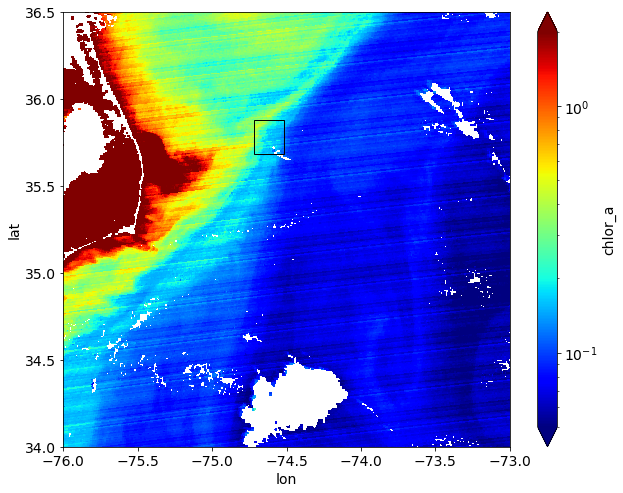

In [204]:
fig,ax = plt.subplots(figsize=(10,8))

chl_ds.chlor_a.plot(ax=ax,x='lon', y='lat', cmap='jet',vmax=2, vmin=0.05,norm=colors.LogNorm())
ax.set_xlim(-76,-73)
ax.set_ylim(34,36.5)
# Create a Rectangle patch
rect = patches.Rectangle((-74.71593, 35.88143), .2, -.2, linewidth=1, edgecolor='black', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
# fig.savefig('study_area_chla_V2021239182400_L2_SNPP_OC.png')

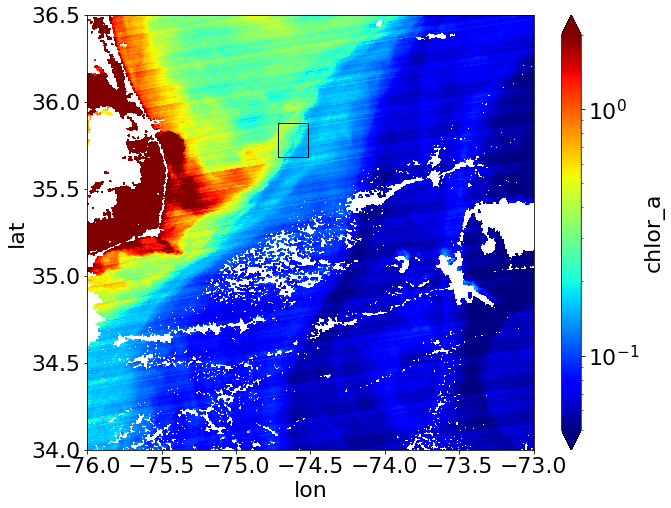

In [364]:
fig,ax = plt.subplots(figsize=(10,8))

chl_ds.chlor_a.plot(ax=ax,x='lon', y='lat', cmap='jet',vmax=2, vmin=0.05,norm=colors.LogNorm())
ax.set_xlim(-76,-73)
ax.set_ylim(34,36.5)
# Create a Rectangle patch
rect = patches.Rectangle((-74.71593, 35.88143), .2, -.2, linewidth=1, edgecolor='black', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
# fig.savefig('study_area_chla_V2021240180600_L2_SNPP_OC.png')

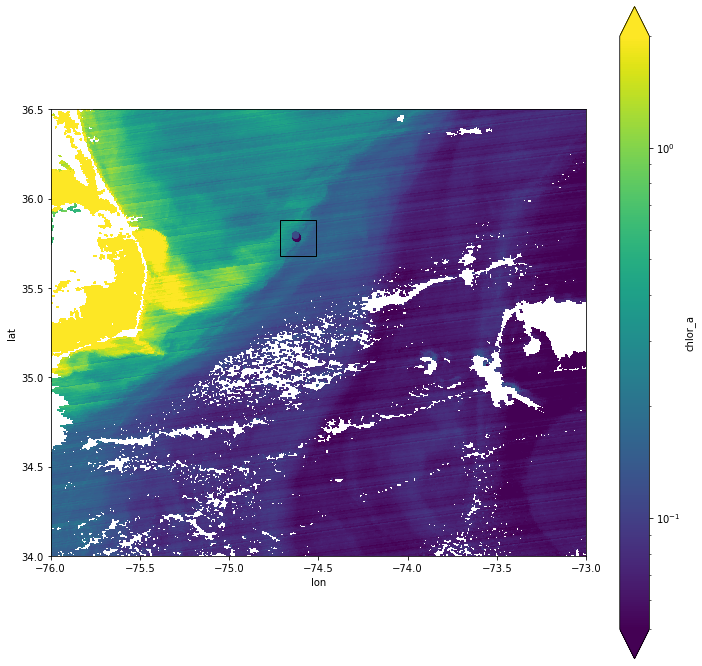

In [37]:
fig,ax = plt.subplots(figsize=(12,12))
chl_ds.chlor_a.plot(x='lon', y='lat', vmax=2, vmin=0.05, cmap='viridis', norm=colors.LogNorm())
ax.set_xlim(-76,-73)
ax.set_ylim(34,36.5)
gdf3.plot(column='chla',ax=ax, vmax=.3, vmin=0.2, cmap='viridis',alpha=0.2,)# norm=colors.LogNorm())

# Create a Rectangle patch
rect = patches.Rectangle((-74.71593, 35.88143), .2, -.2, linewidth=1, edgecolor='black', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


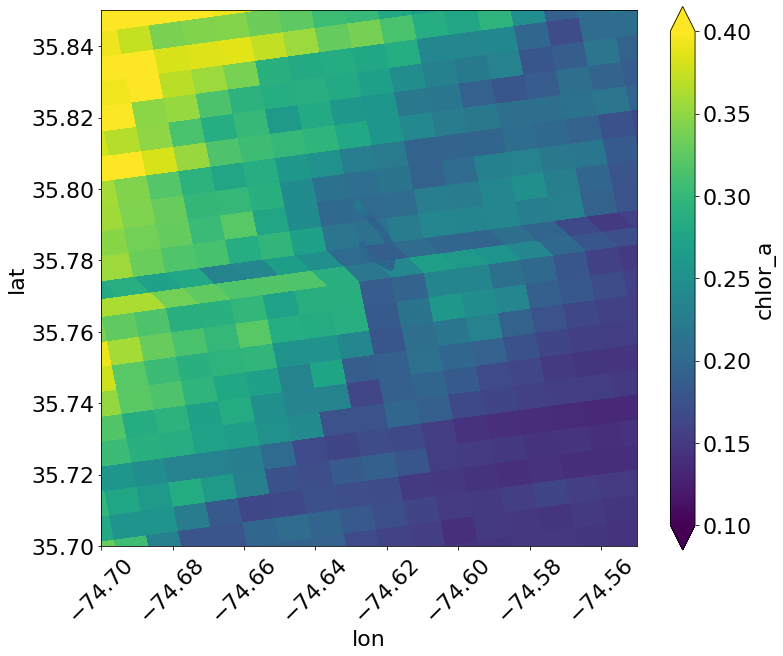

In [348]:
fig,ax = plt.subplots(figsize=(12,10))
chl_ds.chlor_a.plot(x='lon', y='lat', vmax=.4, vmin=0.1, cmap='viridis')
ax.set_xlim(-74.7,-74.55)
ax.set_ylim(35.7,35.85)
gdf3.plot(column='chla',ax=ax, vmax=.4, vmin=0.1, cmap='viridis',alpha=0.2,)# norm=colors.LogNorm())

# # Create a Rectangle patch
# rect = patches.Rectangle((-74.71593, 35.88143), .2, -.2, linewidth=1, edgecolor='black', facecolor='none')

# # Add the patch to the Axes
# ax.add_patch(rect)
ax.tick_params(axis='x', rotation=45)
# ax.set_title('VIIRS Aug 26th 2021')
fig.show()
plt.savefig('chla_map_uas_240_gdf3.png',)

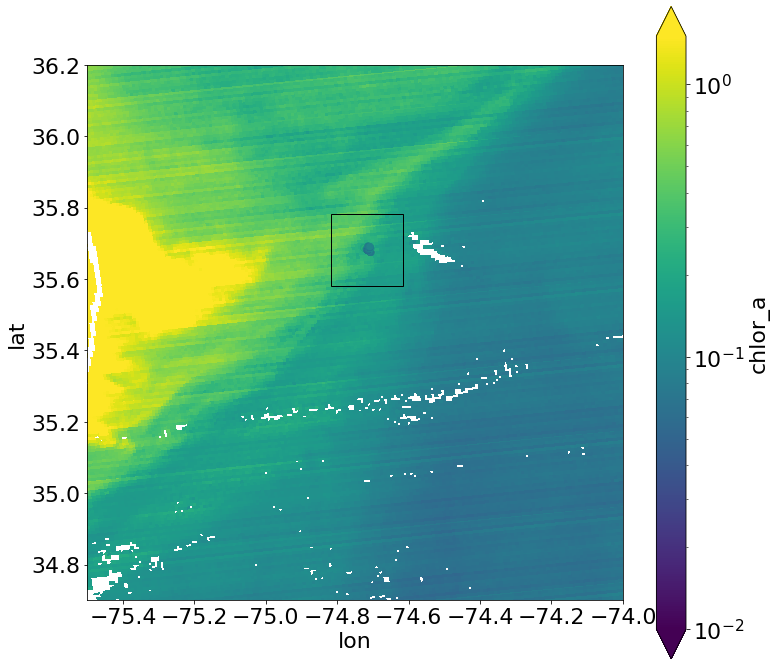

In [324]:
fig,ax = plt.subplots(figsize=(12,12))
chl_ds.chlor_a.plot(x='lon', y='lat', vmax=1.5, vmin=0.01, cmap='viridis', norm=colors.LogNorm())
ax.set_xlim(-75.5,-74)
ax.set_ylim(34.7,36.2)
gdf1.plot(column='chla',ax=ax, vmax=.3, vmin=0.2, cmap='viridis',alpha=0.2,)# norm=colors.LogNorm())

# Create a Rectangle patch
rect = patches.Rectangle((-74.81593, 35.78143), .2, -.2, linewidth=1, edgecolor='black', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

<AxesSubplot:xlabel='lon', ylabel='lat'>

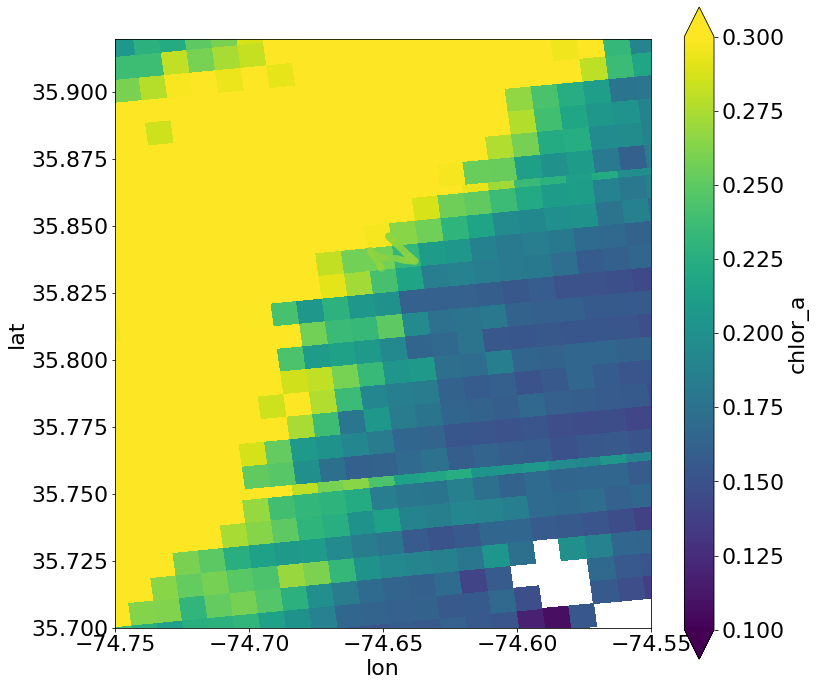

In [325]:
fig,ax = plt.subplots(figsize=(12,12))
chl_ds.chlor_a.plot(x='lon', y='lat', vmax=.3, vmin=0.1, cmap='viridis')
ax.set_xlim(-74.75,-74.55)
ax.set_ylim(35.7,35.92)
gdf2.plot(column='chla',ax=ax, vmax=.3, vmin=0.1, cmap='viridis',alpha=0.2,)# norm=colors.LogNorm())

# # Create a Rectangle patch
# rect = patches.Rectangle((-74.75, 35.93), .2, -.2, linewidth=1, edgecolor='black', facecolor='none')

# # Add the patch to the Axes
# ax.add_patch(rect)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


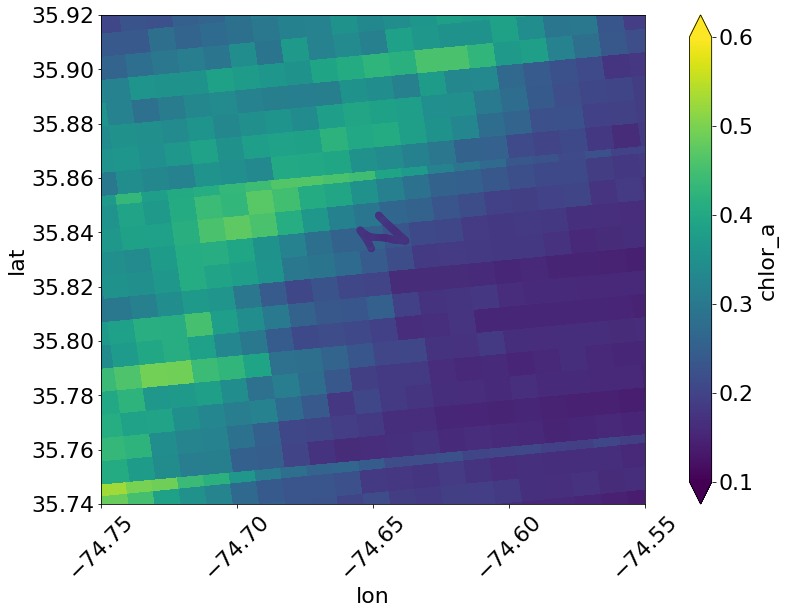

In [205]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))

chl_ds.chlor_a.plot(ax=ax,x='lon', y='lat', vmax=.6, vmin=0.1, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.75,-74.55)
ax.set_ylim(35.74,35.92)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf2.plot(column='chla',ax=ax, vmax=0.6,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())
ax.tick_params(axis='x', rotation=45)

fig.show()
plt.savefig('chla_map_uas_239_gdf2.png',)

(array([ 16.,  11., 107., 104.,  29.,  25.,  15.,   3.,   1.,   2.]),
 array([0.16329076, 0.1663642 , 0.16943764, 0.17251107, 0.17558451,
        0.17865795, 0.18173139, 0.18480483, 0.18787826, 0.1909517 ,
        0.19402514]),
 <BarContainer object of 10 artists>)

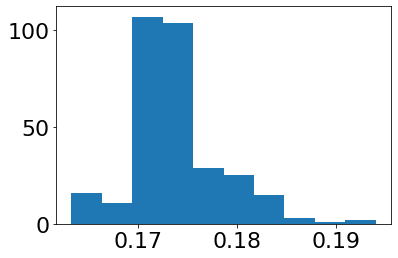

In [224]:
plt.hist(gdf2.chla)

<AxesSubplot:>

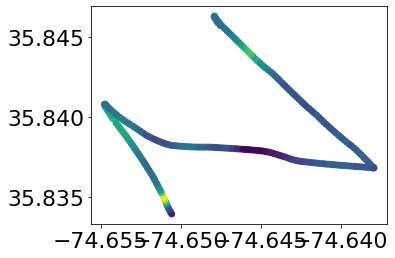

In [232]:
gdf2.iloc[:-90].plot(column='chla')

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


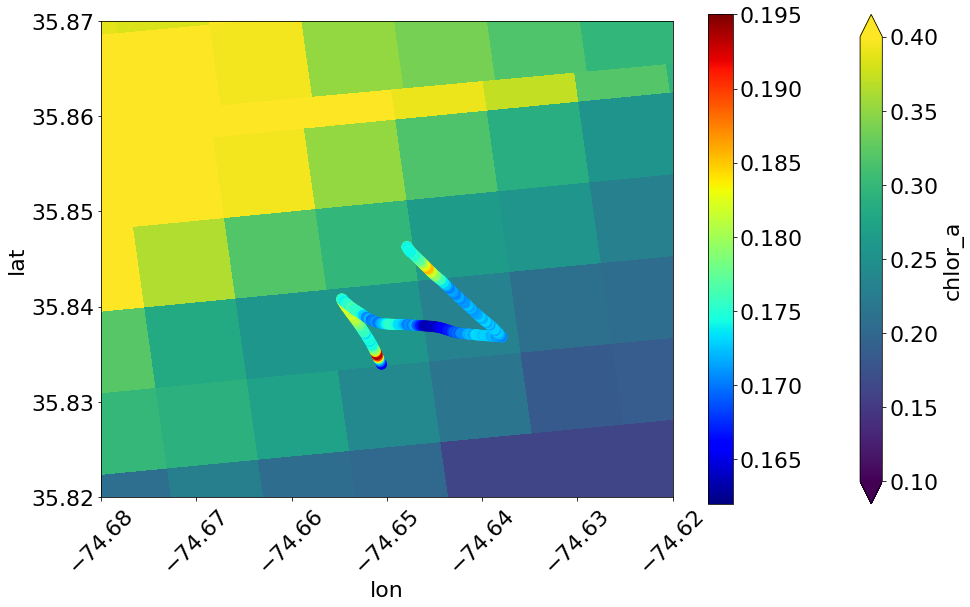

In [233]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))

chl_ds.chlor_a.plot(ax=ax,x='lon', y='lat', vmax=.4, vmin=0.1, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.68,-74.62)
ax.set_ylim(35.82,35.87)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf2.iloc[:-90].plot(column='chla',ax=ax, vmax=0.195,vmin=.162, cmap='jet',s=100, legend=True, label='UAS chlor_a')# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())
ax.tick_params(axis='x', rotation=45)

fig.show()
plt.savefig('chla_map_uas_239_gdf2_zoom.png',dpi=300)

(array([24., 60., 51., 16.,  2.,  5.,  9., 10., 10.,  1.]),
 array([0.18932795, 0.19353786, 0.19774776, 0.20195767, 0.20616757,
        0.21037748, 0.21458738, 0.21879729, 0.22300719, 0.2272171 ,
        0.231427  ]),
 <BarContainer object of 10 artists>)

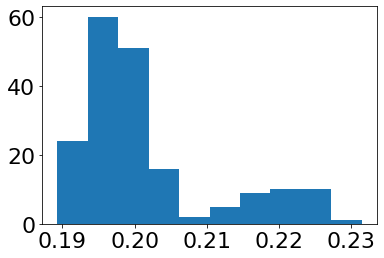

In [352]:
plt.hist(gdf3.chla)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


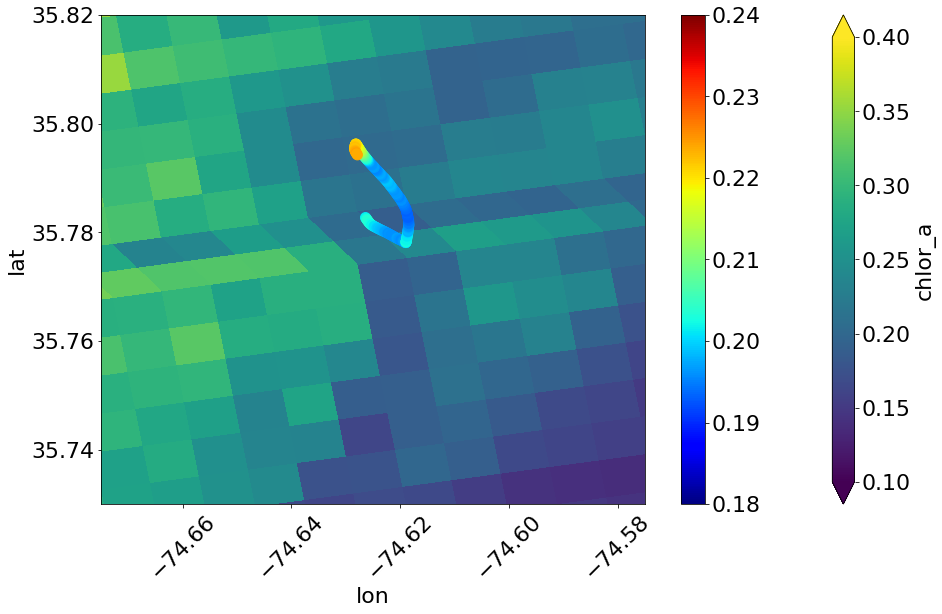

In [363]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)

chl_ds.chlor_a.plot(ax=ax,x='lon', y='lat', vmax=.4, vmin=0.1, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.675,-74.575)
ax.set_ylim(35.73,35.82)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf3.plot(gdf3.chla.rolling(12).mean(),ax=ax, vmax=0.24,vmin=.18, 
          cmap='jet',alpha=1,s=100, legend=True)# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmax=.4, vmin=0.1, cmap='viridis',alpha=0.2,)# norm=colors.LogNorm())

# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())

ax.tick_params(axis='x', rotation=45)

fig.show()
plt.savefig('chla_map_uas_240_gdf3_zoom.png',dpi=300)

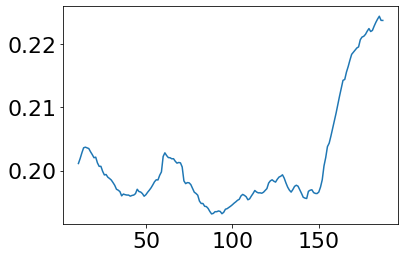

In [361]:
plt.plot(gdf3.chla.rolling(12).mean())

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


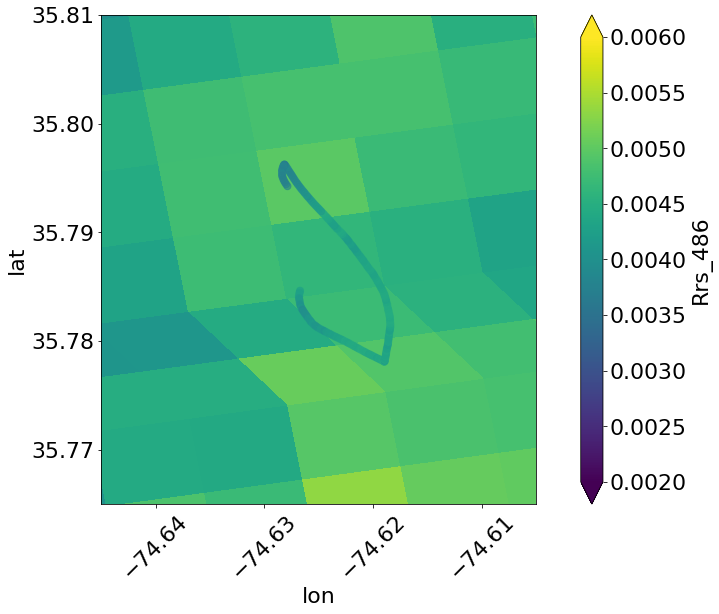

In [45]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)

rrs_ds.Rrs_486.plot(ax=ax,x='lon', y='lat', vmax=.006, vmin=0.002, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.645,-74.605)
ax.set_ylim(35.765,35.81)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf3.plot(gdf3.lw_spectra_float.map(lambda x: x[0]),ax=ax, vmax=0.006,vmin=.002, cmap='viridis',alpha=0.6,s=50)# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())

fig.show()
# plt.savefig('chla_map_uas.png',dpi=300)

In [130]:
rrs_ds

<xarray.Dataset>
Dimensions:  (x: 3232, y: 3200)
Coordinates:
    lat      (x, y) float32 33.29878 33.298492 33.29821 ... 47.546436 47.53859
    lon      (x, y) float32 -59.39956 -59.41746 ... -103.347694 -103.36826
Dimensions without coordinates: x, y
Data variables:
    Rrs_410  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_443  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_486  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_551  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_671  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    variable:  Rrs_410

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


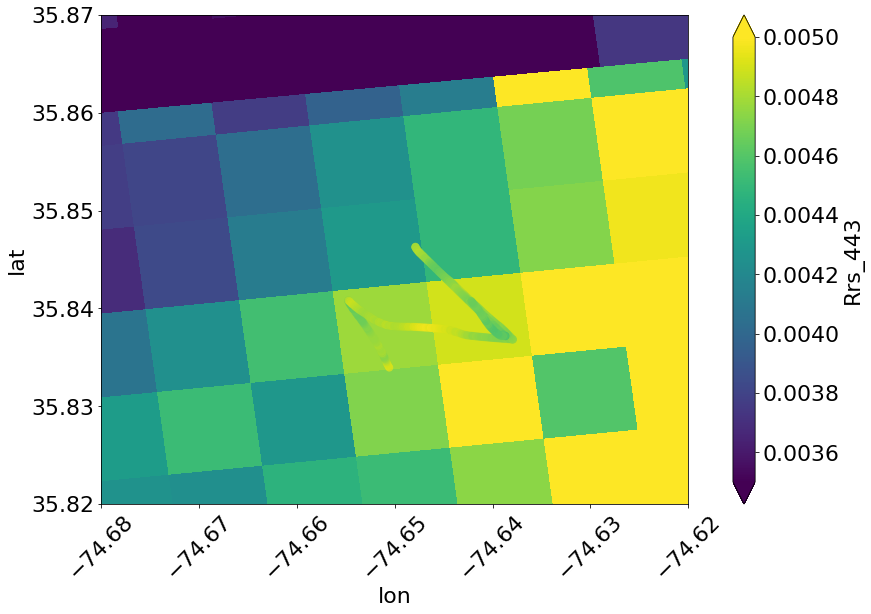

In [60]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)

rrs_ds.Rrs_443.plot(ax=ax,x='lon', y='lat', vmax=.005, vmin=0.0035, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.68,-74.62)
ax.set_ylim(35.82,35.87)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf2.plot(gdf2.lw_spectra_float.map(lambda x: x[0]),ax=ax, vmax=0.005,vmin=.0035, cmap='viridis',alpha=0.6,s=50)# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())

fig.show()
# plt.savefig('chla_map_uas.png',dpi=300)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


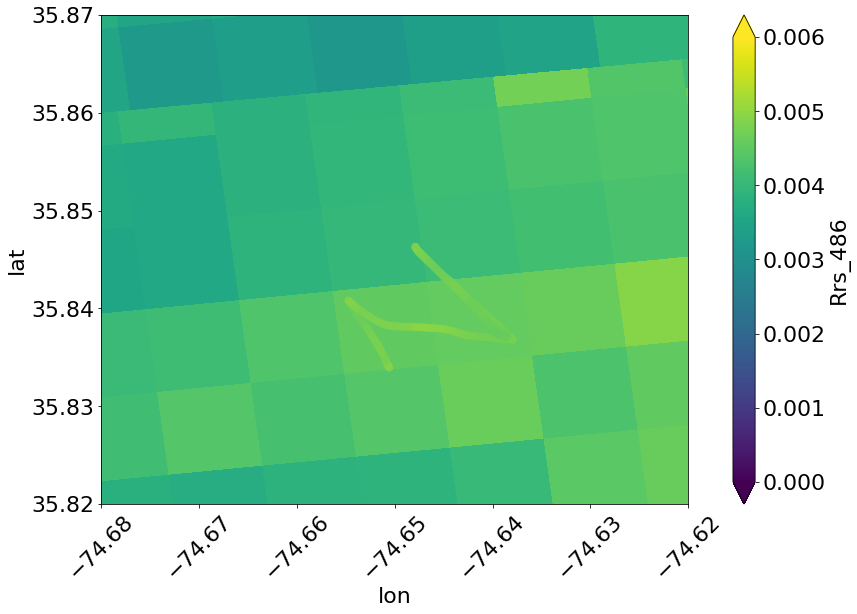

In [61]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)

rrs_ds.Rrs_486.plot(ax=ax,x='lon', y='lat', vmax=.006, vmin=0.0, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.68,-74.62)
ax.set_ylim(35.82,35.87)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf2.plot(gdf2.lw_spectra_float.map(lambda x: x[0]),ax=ax, vmax=0.006,vmin=.0, cmap='viridis',alpha=0.6,s=50)# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())

fig.show()
# plt.savefig('chla_map_uas.png',dpi=300)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


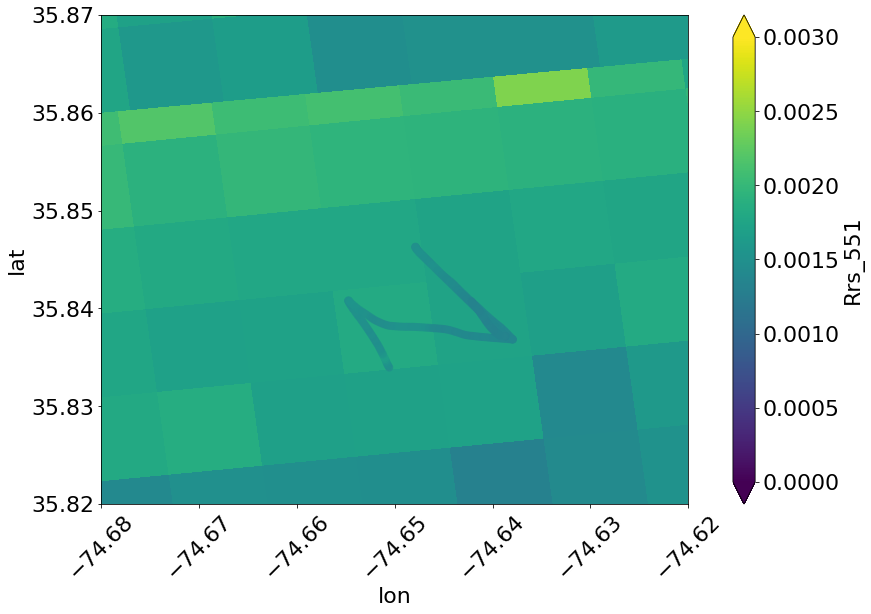

In [62]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)

rrs_ds.Rrs_551.plot(ax=ax,x='lon', y='lat', vmax=.003, vmin=0.0, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.68,-74.62)
ax.set_ylim(35.82,35.87)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf2.plot(gdf2.lw_spectra_float.map(lambda x: x[1]),ax=ax, vmax=0.003,vmin=.0, cmap='viridis',alpha=0.6,s=50)# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())

fig.show()
# plt.savefig('chla_map_uas.png',dpi=300)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


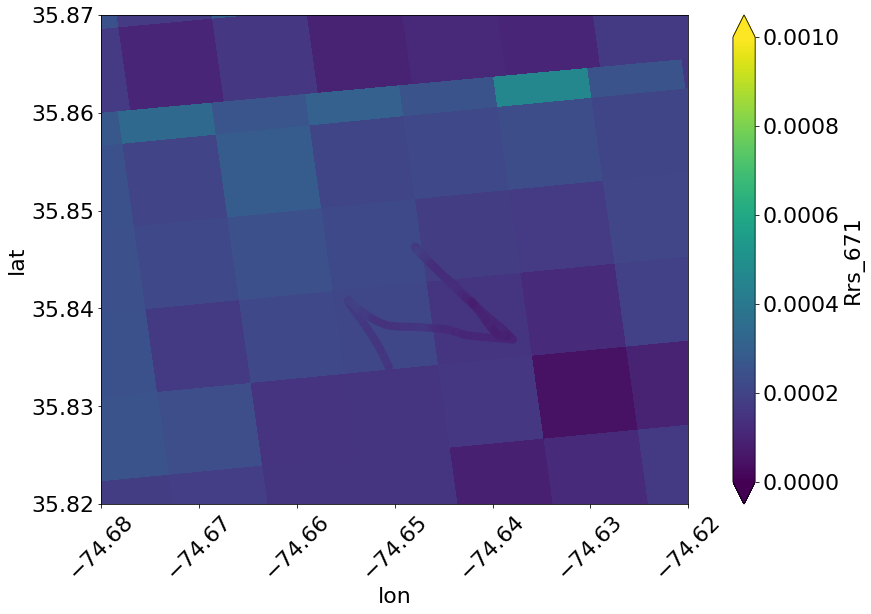

In [63]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)

rrs_ds.Rrs_671.plot(ax=ax,x='lon', y='lat', vmax=.001, vmin=0.0, cmap='viridis')# norm=colors.LogNorm())
#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
ax.set_xlim(-74.68,-74.62)
ax.set_ylim(35.82,35.87)

# gdf1.plot(column='chla',ax=ax, vmax=0.4,vmin=.1, cmap='viridis',alpha=0.6)# norm=colors.LogNorm())
gdf2.plot(gdf2.lw_spectra_float.map(lambda x: x[2]),ax=ax, vmax=0.001,vmin=.0, cmap='viridis',alpha=0.6,s=50)# norm=colors.LogNorm())
# gdf3.plot(column='chla',ax=ax, vmin=0.04,vmax=.18, cmap='viridis',alpha=0.6,)# norm=colors.LogNorm())

fig.show()
# plt.savefig('chla_map_uas.png',dpi=300)

In [182]:
rrs_ds

<xarray.Dataset>
Dimensions:  (x: 3232, y: 3200)
Coordinates:
    lat      (x, y) float32 33.29878 33.298492 33.29821 ... 47.546436 47.53859
    lon      (x, y) float32 -59.39956 -59.41746 ... -103.347694 -103.36826
Dimensions without coordinates: x, y
Data variables:
    Rrs_410  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_443  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_486  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_551  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rrs_671  (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    variable:  Rrs_410

For 239

In [207]:
rrs_ds_subset = rrs_ds.where((rrs_ds.lon < -74.635) & (rrs_ds.lon > -74.655),drop=True)
rrs_ds_subset239 = rrs_ds_subset.where((rrs_ds_subset.lat < 35.85) & (rrs_ds_subset.lat > 35.83),drop=True)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


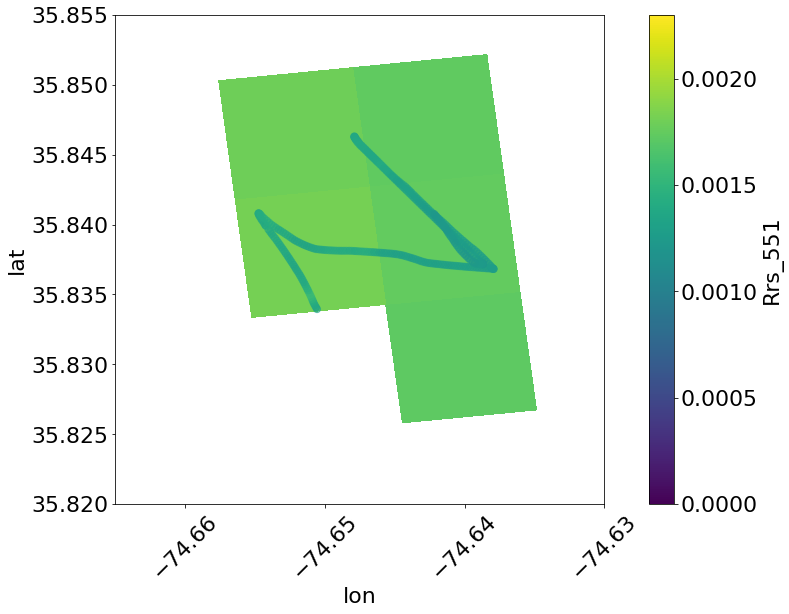

In [228]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)
ax.set_xlim(-74.665,-74.63)
ax.set_ylim(35.82,35.855)

rrs_ds_subset239.Rrs_551.plot(ax=ax,x='lon', y='lat', vmax=.0023, vmin=0.0, cmap='viridis')# norm=colors.LogNorm())
gdf2.plot(gdf2.lw_spectra_float.map(lambda x: x[1]),ax=ax, vmax=0.0025,vmin=.0, cmap='viridis',alpha=0.6,s=50)# norm=colors.LogNorm())

#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
fig.show()
# plt.savefig('chla_map_uas.png',dpi=300)

For 240

In [242]:
rrs_ds_subset = rrs_ds.where((rrs_ds.lon < -74.615) & (rrs_ds.lon > -74.635),drop=True)
rrs_ds_subset240 = rrs_ds_subset.where((rrs_ds_subset.lat < 35.80) & (rrs_ds_subset.lat > 35.778),drop=True)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


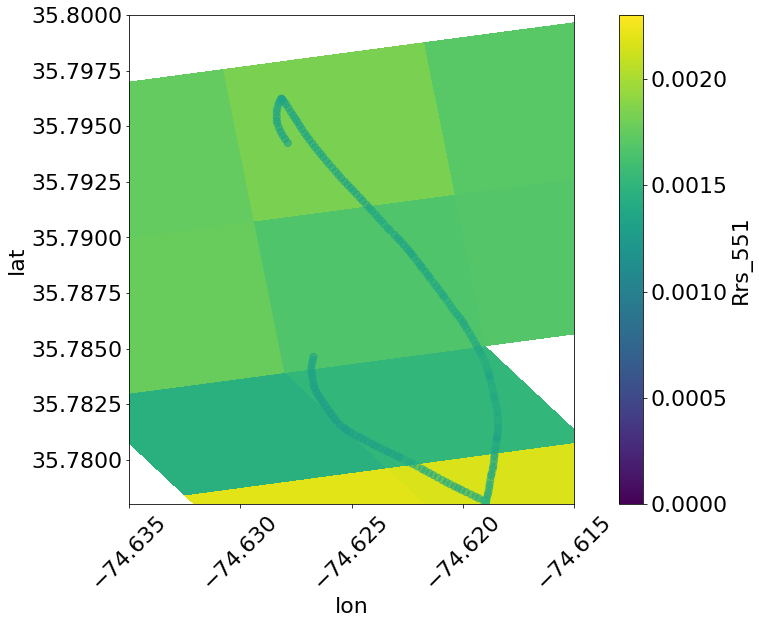

In [243]:
plt.rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(16,9))
ax.tick_params(axis='x', rotation=45)
ax.set_xlim(-74.635,-74.615)
ax.set_ylim(35.778,35.80)

rrs_ds_subset240.Rrs_551.plot(ax=ax,x='lon', y='lat', vmax=.0023, vmin=0.0, cmap='viridis')# norm=colors.LogNorm())
gdf3.plot(gdf3.lw_spectra_float.map(lambda x: x[1]),ax=ax, vmax=0.0025,vmin=.0, cmap='viridis',alpha=0.6,s=50)# norm=colors.LogNorm())

#sst_ds.sst.plot(ax=ax, x='lon', y='lat', vmax=17.5, vmin=26.5, cmap='inferno')
fig.show()
# plt.savefig('chla_map_uas.png',dpi=300)

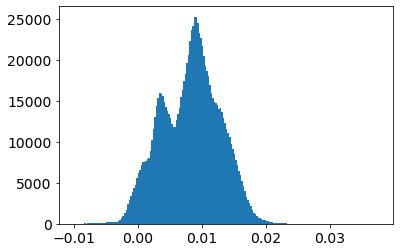

In [209]:
plt.hist(rrs_ds.Rrs_410.values.flatten(),bins=200)
plt.show()

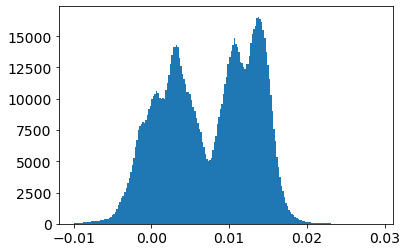

In [220]:
plt.hist(rrs_ds.Rrs_410.values.flatten(),bins=200)
plt.show()

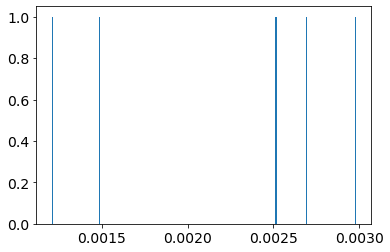

In [210]:
plt.hist(rrs_ds_subset239.Rrs_410.values.flatten(),bins=200)
plt.show()

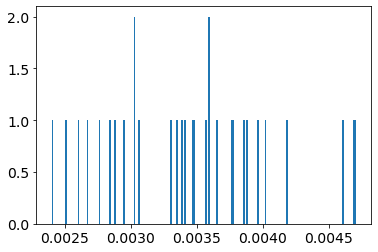

In [221]:
plt.hist(rrs_ds_subset240.Rrs_410.values.flatten(),bins=200)
plt.show()

In [338]:
[475, 560, 668, 842, 717]

[475, 560, 668, 842, 717]

In [158]:
len(rrs_ds_subset.Rrs_410.values.flatten())

24056

In [171]:
len(rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())])

5

In [222]:
trios_gdf

TimeStamp       320       321       322  \
utc_dt                                                                   
2021-08-27 13:11:50  08/27/2021 09:11:50  0.005971  0.005748  0.005671   
2021-08-27 13:12:00  08/27/2021 09:12:00  0.005438  0.005245  0.005187   
2021-08-27 13:12:10  08/27/2021 09:12:10  0.003654  0.003467  0.003400   
2021-08-27 13:12:20  08/27/2021 09:12:20  0.007854  0.007608  0.007533   
2021-08-27 13:12:30  08/27/2021 09:12:30  0.006221  0.006000  0.005932   
...                                  ...       ...       ...       ...   
2021-08-27 21:23:00  08/27/2021 17:23:00  0.003818  0.003632  0.003598   
2021-08-27 21:23:10  08/27/2021 17:23:10  0.005795  0.005568  0.005513   
2021-08-27 21:23:20  08/27/2021 17:23:20  0.008748  0.008525  0.008494   
2021-08-27 21:23:30  08/27/2021 17:23:30  0.004317  0.004147  0.004116   
2021-08-27 21:23:40  08/27/2021 17:23:40  0.004363  0.004181  0.004144   

                          323       324       325       326       327  \
utc_dt                                                                  
2021-08-27 13:11:50  0.005638  0.005632  0.005615  0.005598  0.005683   
2021-08-27 13:12:00  0.005165  0.005162  0.005144  0.005109  0.005180   
2021-08-27 13:12:10  0.003373  0.003371  0.003362  0.003350  0.003438   
2021-08-27 13:12:20  0.007509  0.007507  0.007492  0.007473  0.007558   
2021-08-27 13:12:30  0.005905  0.005904  0.005892  0.005890  0.005996   
...                       ...       ...       ...       ...       ...   
2021-08-27 21:23:00  0.003611  0.003629  0.003631  0.003619  0.003719   
2021-08-27 21:23:10  0.005503  0.005508  0.005502  0.005504  0.005622   
2021-08-27 21:23:20  0.008473  0.008466  0.008453  0.008473  0.008610   
2021-08-27 21:23:30  0.004121  0.004135  0.004136  0.004131  0.004232   
2021-08-27 21:23:40  0.004145  0.004159  0.004159  0.004154  0.004253   

                          328  ...       946       947       948       949  \
utc_dt                         ...                                           
2021-08-27 13:11:50  0.005812  ...  0.001663  0.001679  0.001718  0.001743   
2021-08-27 13:12:00  0.005296  ...  0.001536  0.001591  0.001678  0.001715   
2021-08-27 13:12:10  0.003571  ...  0.001291  0.001318  0.001332  0.001301   
2021-08-27 13:12:20  0.007686  ...  0.002283  0.002339  0.002401  0.002391   
2021-08-27 13:12:30  0.006146  ...  0.001192  0.001266  0.001403  0.001503   
...                       ...  ...       ...       ...       ...       ...   
2021-08-27 21:23:00  0.003868  ...  0.000510  0.000552  0.000625  0.000615   
2021-08-27 21:23:10  0.005784  ...  0.001155  0.001208  0.001304  0.001364   
2021-08-27 21:23:20  0.008787  ...  0.004994  0.004956  0.004943  0.004839   
2021-08-27 21:23:30  0.004379  ...  0.000696  0.000708  0.000795  0.000840   
2021-08-27 21:23:40  0.004396  ...  0.001024  0.001024  0.001054  0.001106   

                          950            datetime        lat        lon  \
utc_dt                                                                    
2021-08-27 13:11:50  0.001764 2021-08-27 13:11:50  35.678043 -74.749355   
2021-08-27 13:12:00  0.001720 2021-08-27 13:12:00  35.677983 -74.748697   
2021-08-27 13:12:10  0.001316 2021-08-27 13:12:10  35.677955 -74.748045   
2021-08-27 13:12:20  0.002387 2021-08-27 13:12:20  35.677948 -74.747362   
2021-08-27 13:12:30  0.001541 2021-08-27 13:12:30  35.677965 -74.746703   
...                       ...                 ...        ...        ...   
2021-08-27 21:23:00  0.000556 2021-08-27 21:23:00  35.877082 -74.631187   
2021-08-27 21:23:10  0.001392 2021-08-27 21:23:10  35.876862 -74.631302   
2021-08-27 21:23:20  0.004791 2021-08-27 21:23:20  35.876650 -74.631370   
2021-08-27 21:23:30  0.000826 2021-08-27 21:23:30  35.876467 -74.631258   
2021-08-27 21:23:40  0.001159 2021-08-27 21:23:40  35.876372 -74.630962   

                                       geometry  chla_oci  
utc_dt                                                     
2021-08

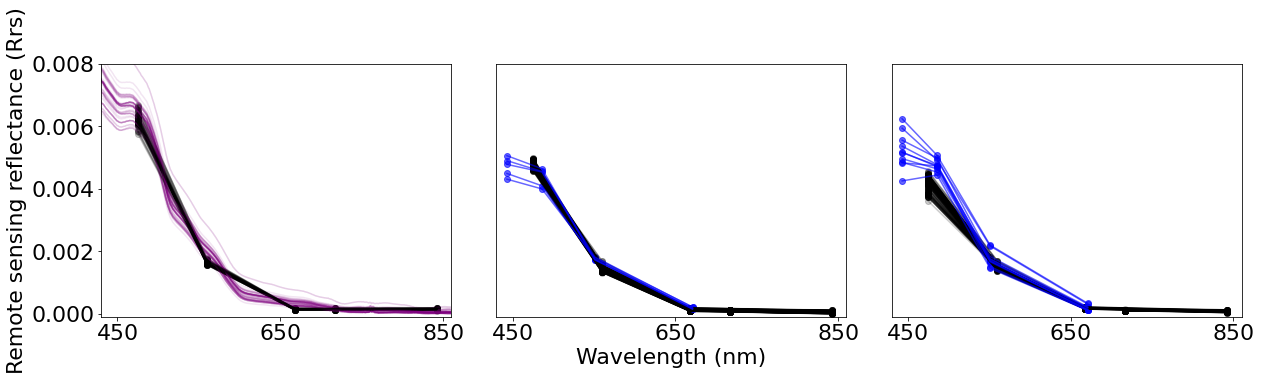

In [270]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

### TriOS

for i in range(len(matched_subset)):
    ax[0].plot(trios_gdf_transect.columns[1:-7].astype(int),corrected_spec[i], color='purple', alpha=0.1)
    ax[0].plot([475, 560, 668, 842, 717],matched_subset.iloc[i].lw_spectra_float, color='black', alpha=0.2)
    ax[0].scatter([475, 560, 668, 842, 717],matched_subset.iloc[i].lw_spectra_float, color='black', alpha=0.2)
ax[0].set_ylabel('Remote sensing reflectance (Rrs)')
# fig.savefig('comparing_trios_to_altum.png',dpi=300)

# VIIRS 239

altum_wavelengths = np.array([475, 560, 668, 842, 717])
altum_wavelengths = np.repeat(altum_wavelengths[:, np.newaxis], len(gdf2.lw_spectra_float.map(lambda x: x[0])), axis=1)

ax[1].scatter(altum_wavelengths,[
                                         gdf2.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[2]),
                                         gdf2.lw_spectra_float.map(lambda x: x[3]),
                                         gdf2.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.2, label='UAS')

ax[1].plot(altum_wavelengths,[
                                         gdf2.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[2]),
                                         gdf2.lw_spectra_float.map(lambda x: x[3]),
                                         gdf2.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.2, label='UAS')

viirs_wavelengths = np.array([443,486,551,671]) #410
viirs_wavelengths = np.repeat(viirs_wavelengths[:, np.newaxis], 
                              len(rrs_ds_subset239.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_443.values.flatten())]), axis=1)

ax[1].scatter(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset239.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_443.values.flatten())],
             rrs_ds_subset239.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_486.values.flatten())],
             rrs_ds_subset239.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_551.values.flatten())],
             rrs_ds_subset239.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

ax[1].plot(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset239.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_443.values.flatten())],
             rrs_ds_subset239.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_486.values.flatten())],
             rrs_ds_subset239.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_551.values.flatten())],
             rrs_ds_subset239.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

# VIIRS 240

altum_wavelengths = np.array([475, 560, 668, 842, 717])
altum_wavelengths = np.repeat(altum_wavelengths[:, np.newaxis], len(gdf3.lw_spectra_float.map(lambda x: x[0])), axis=1)

ax[2].scatter(altum_wavelengths,[
                                         gdf3.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[2]),
                                         gdf3.lw_spectra_float.map(lambda x: x[3]),
                                         gdf3.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.2, label='UAS')

ax[2].plot(altum_wavelengths,[
                                         gdf3.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[2]),
                                         gdf3.lw_spectra_float.map(lambda x: x[3]),
                                         gdf3.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.2, label='UAS')

viirs_wavelengths = np.array([443,486,551,671]) #410
viirs_wavelengths = np.repeat(viirs_wavelengths[:, np.newaxis], 
                              len(rrs_ds_subset240.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_443.values.flatten())]), axis=1)

ax[2].scatter(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset240.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_443.values.flatten())],
             rrs_ds_subset240.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_486.values.flatten())],
             rrs_ds_subset240.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_551.values.flatten())],
             rrs_ds_subset240.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

ax[2].plot(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset240.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_443.values.flatten())],
             rrs_ds_subset240.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_486.values.flatten())],
             rrs_ds_subset240.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_551.values.flatten())],
             rrs_ds_subset240.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

ax[0].set_xlim(430,860)
ax[1].set_xlim(430,860)
ax[2].set_xlim(430,860)

ax[0].set_ylim(-0.0001,0.008)
ax[1].set_ylim(-0.0001,0.008)
ax[2].set_ylim(-0.0001,0.008)

ax[0].set_xticks([450,650,850])
ax[1].set_xticks([450,650,850])
ax[2].set_xticks([450,650,850])

ax[1].set_yticks([])
ax[2].set_yticks([])
ax[1].set_xlabel('Wavelength (nm)')
fig.tight_layout()

fig.savefig('uas_vs_viirs_trios_239and240.png',dpi=300)

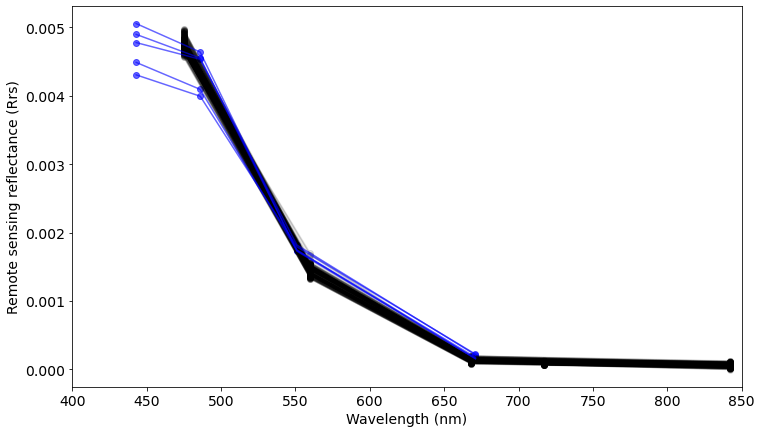

In [215]:
fig, ax = plt.subplots(figsize=(12,7))

# for i in range(len(matched_subset)):
#     ax.plot(trios_gdf_transect.columns[1:-7].astype(int),corrected_spec[i], color='green', alpha=0.1)

altum_wavelengths = np.array([475, 560, 668, 842, 717])
altum_wavelengths = np.repeat(altum_wavelengths[:, np.newaxis], len(gdf2.lw_spectra_float.map(lambda x: x[0])), axis=1)

ax.scatter(altum_wavelengths,[
                                         gdf2.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[2]),
                                         gdf2.lw_spectra_float.map(lambda x: x[3]),
                                         gdf2.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.1, label='UAS')

ax.plot(altum_wavelengths,[
                                         gdf2.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf2.lw_spectra_float.map(lambda x: x[2]),
                                         gdf2.lw_spectra_float.map(lambda x: x[3]),
                                         gdf2.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.1, label='UAS')

viirs_wavelengths = np.array([443,486,551,671]) #410
viirs_wavelengths = np.repeat(viirs_wavelengths[:, np.newaxis], 
                              len(rrs_ds_subset239.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_443.values.flatten())]), axis=1)

ax.scatter(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset239.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_443.values.flatten())],
             rrs_ds_subset239.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_486.values.flatten())],
             rrs_ds_subset239.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_551.values.flatten())],
             rrs_ds_subset239.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

ax.plot(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset239.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_443.values.flatten())],
             rrs_ds_subset239.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_486.values.flatten())],
             rrs_ds_subset239.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_551.values.flatten())],
             rrs_ds_subset239.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset239.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

ax.set_xlim(400,850)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
fig.savefig('uas_vs_viirs_239.png')
plt.show()

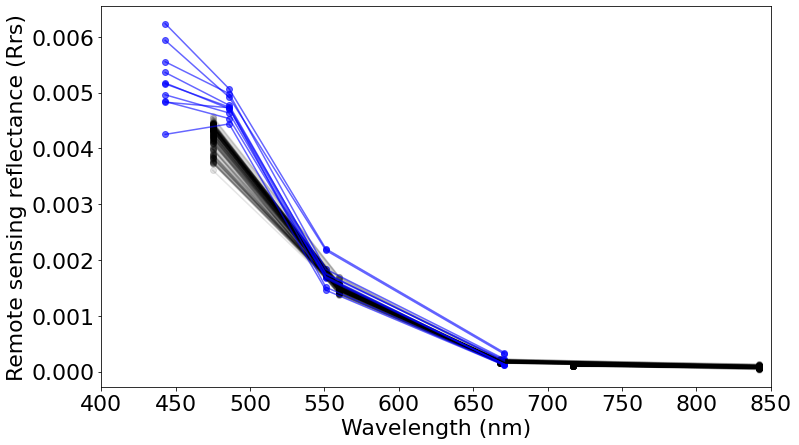

In [244]:
fig, ax = plt.subplots(figsize=(12,7))

# for i in range(len(matched_subset)):
#     ax.plot(trios_gdf_transect.columns[1:-7].astype(int),corrected_spec[i], color='green', alpha=0.1)

altum_wavelengths = np.array([475, 560, 668, 842, 717])
altum_wavelengths = np.repeat(altum_wavelengths[:, np.newaxis], len(gdf3.lw_spectra_float.map(lambda x: x[0])), axis=1)

ax.scatter(altum_wavelengths,[
                                         gdf3.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[2]),
                                         gdf3.lw_spectra_float.map(lambda x: x[3]),
                                         gdf3.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.1, label='UAS')

ax.plot(altum_wavelengths,[
                                         gdf3.lw_spectra_float.map(lambda x: x[0]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[1]), 
                                         gdf3.lw_spectra_float.map(lambda x: x[2]),
                                         gdf3.lw_spectra_float.map(lambda x: x[3]),
                                         gdf3.lw_spectra_float.map(lambda x: x[4])], 
           color='black', alpha=0.1, label='UAS')

viirs_wavelengths = np.array([443,486,551,671]) #410
viirs_wavelengths = np.repeat(viirs_wavelengths[:, np.newaxis], 
                              len(rrs_ds_subset240.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_443.values.flatten())]), axis=1)

ax.scatter(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset240.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_443.values.flatten())],
             rrs_ds_subset240.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_486.values.flatten())],
             rrs_ds_subset240.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_551.values.flatten())],
             rrs_ds_subset240.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

ax.plot(viirs_wavelengths,
         [   
             #rrs_ds_subset.Rrs_410.values.flatten()[~np.isnan(rrs_ds_subset.Rrs_410.values.flatten())],
             rrs_ds_subset240.Rrs_443.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_443.values.flatten())],
             rrs_ds_subset240.Rrs_486.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_486.values.flatten())],
             rrs_ds_subset240.Rrs_551.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_551.values.flatten())],
             rrs_ds_subset240.Rrs_671.values.flatten()[~np.isnan(rrs_ds_subset240.Rrs_671.values.flatten())],
         ], color='blue', alpha=0.6, label='VIIRS'
        )

ax.set_xlim(400,850)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('uas_vs_viirs_240.png')
plt.show()

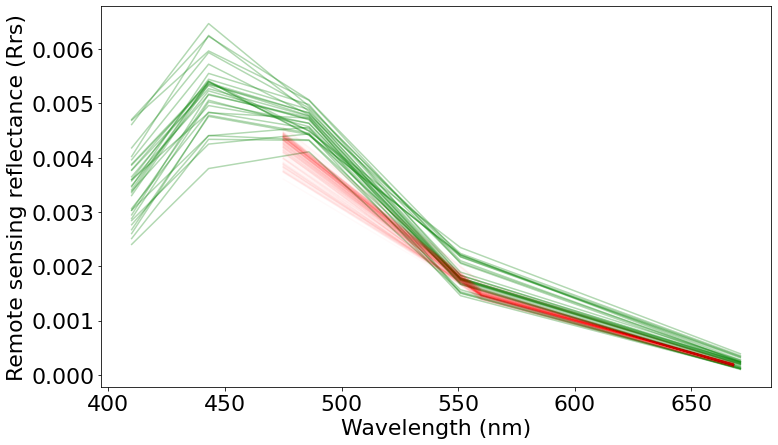

In [49]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot([410,443,486,551,671],
         [   
             rrs_ds_subset.Rrs_410.values.flatten(),
             rrs_ds_subset.Rrs_443.values.flatten(),
             rrs_ds_subset.Rrs_486.values.flatten(),
             rrs_ds_subset.Rrs_551.values.flatten(),
             rrs_ds_subset.Rrs_671.values.flatten()
         ], color='green', alpha=0.3, label='VIIRS'
        )
ax.plot([475, 560, 668],[gdf3.lw_spectra_float.map(lambda x: x[0]), 
                         gdf3.lw_spectra_float.map(lambda x: x[1]), 
                         gdf3.lw_spectra_float.map(lambda x: x[2])], color='red', alpha=0.02, label='UAS')

ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('uas_vs_viirs_240.png')
plt.show()

In [50]:
viirs_oci = oc_index(rrs_ds_subset.Rrs_486.values.flatten(),
             rrs_ds_subset.Rrs_551.values.flatten(),
             rrs_ds_subset.Rrs_671.values.flatten())

In [51]:
np.mean(viirs_oci[~np.isnan(viirs_oci)])

0.21119858

In [52]:
np.mean(gdf3.chla)

0.2018235987129742

In [343]:
np.count_nonzero(~np.isnan(rrs_ds_subset.Rrs_410.values.flatten()))

17

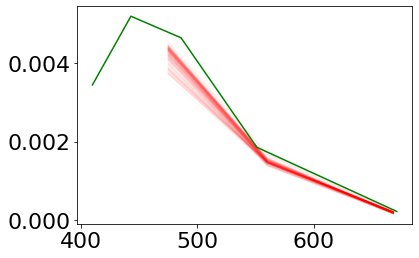

In [53]:
plt.plot([475, 560, 668],[gdf3.lw_spectra_float.map(lambda x: x[0]), 
                         gdf3.lw_spectra_float.map(lambda x: x[1]), 
                         gdf3.lw_spectra_float.map(lambda x: x[2])], color='red', alpha=0.02)

plt.plot([410,443,486,551,671],
         [rrs_ds_subset.Rrs_410.mean(),
          rrs_ds_subset.Rrs_443.mean(),
          rrs_ds_subset.Rrs_486.mean(),
          rrs_ds_subset.Rrs_551.mean(),
          rrs_ds_subset.Rrs_671.mean()], 
         color='green')
plt.show()

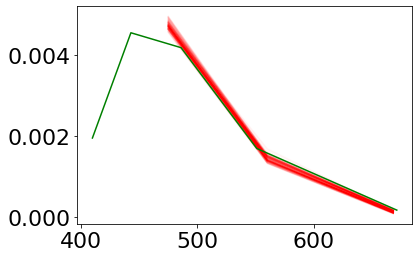

In [66]:
plt.plot([475, 560, 668],[gdf2.lw_spectra_float.map(lambda x: x[0]), 
                         gdf2.lw_spectra_float.map(lambda x: x[1]), 
                         gdf2.lw_spectra_float.map(lambda x: x[2])], color='red', alpha=0.02)

plt.plot([410,443,486,551,671],
         [rrs_ds_subset.Rrs_410.mean(),
          rrs_ds_subset.Rrs_443.mean(),
          rrs_ds_subset.Rrs_486.mean(),
          rrs_ds_subset.Rrs_551.mean(),
          rrs_ds_subset.Rrs_671.mean()], 
         color='green')
plt.show()

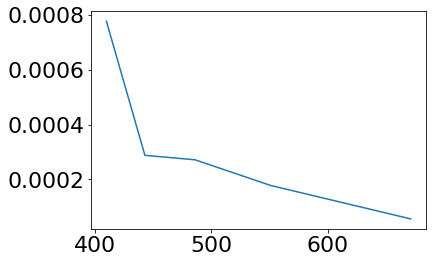

In [345]:
plt.plot([410,443,486,551,671],[rrs_ds_subset.Rrs_410.std(),rrs_ds_subset.Rrs_443.std(),rrs_ds_subset.Rrs_486.std(),rrs_ds_subset.Rrs_551.std(),rrs_ds_subset.Rrs_671.std()])

### pull out values from OLCI based on drone locations

(35.7, 35.92)

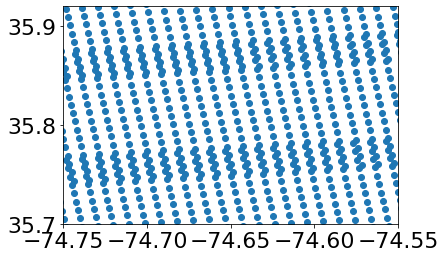

In [56]:
fig,ax = plt.subplots()
ax.scatter(chl_ds.lon, chl_ds.lat)
ax.set_xlim(-74.75,-74.55)
ax.set_ylim(35.7,35.92)

In [86]:
c = np.maximum(abslon, abslat)
c

NameError: name 'abslon' is not defined

In [ ]:
([xloc], [yloc]) = np.where(c == np.min(c))
xloc,yloc

(35.7, 35.92)

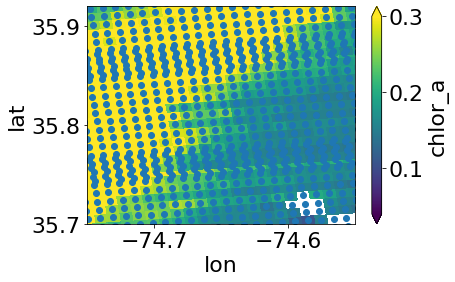

In [57]:
fig,ax = plt.subplots()
chl_ds.chlor_a.plot(ax=ax,x='lon', y='lat', vmax=.3, vmin=0.04, cmap='viridis')
ax.scatter(chl_ds.lon, chl_ds.lat)
ax.set_xlim(-74.75,-74.55)
ax.set_ylim(35.7,35.92)

Show that we can find the nearest pixel to the drone chla point

In [65]:
[xloc], [yloc]

([1034], [903])

In [67]:
chl_ds.isel(x=xloc, y=yloc)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 35.83806
    lon      float32 -74.65103
Data variables:
    chlor_a  float32 0.25736877
Attributes:
    variable:  Chlorophyll-a

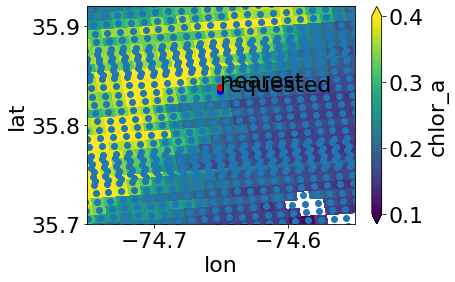

In [68]:
centroids = gdf2.centroid

fig,ax = plt.subplots()
chl_ds.chlor_a.plot(ax=ax,x='lon', y='lat', vmax=.4, vmin=0.1, cmap='viridis')
ax.scatter(chl_ds.lon, chl_ds.lat)

# I want to find the chla at a certain lat/lon point.
lat = centroids.y.iloc[0]
lon = centroids.x.iloc[0]

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(chl_ds.lat-lat)
abslon = np.abs(chl_ds.lon-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# # Now I can use that index location to get the values at the x/y diminsion
point_ds = chl_ds.isel(x=xloc, y=yloc)

# Plot requested lat/lon point blue
ax.scatter(lon, lat, color='b')
ax.text(lon, lat, 'requested')

# # Plot nearest point in the array red
ax.scatter(point_ds.lon, point_ds.lat, color='r')
ax.text(point_ds.lon, point_ds.lat, 'nearest')
ax.set_xlim(-74.75,-74.55)
ax.set_ylim(35.7,35.92)
plt.show()

In [9]:
# this is based on https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
values = []
centroids = gdf3.centroid
for i in range(len(centroids)):
    # I want to find the speed at a certain lat/lon point.
    lat = centroids.y.iloc[i]
    lon = centroids.x.iloc[i]

    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(chl_ds.lat-lat)
    abslon = np.abs(chl_ds.lon-lon)
    c = np.maximum(abslon, abslat)
    if len(np.where(c == np.min(c))[0])==2:
        xloc = np.where(c == np.min(c))[0][0]
        yloc = np.where(c == np.min(c))[1][0]
    else:
        ([xloc], [yloc]) = np.where(c == np.min(c))
    # Now I can use that index location to get the values at the x/y diminsion
    point_ds = chl_ds.isel(x=xloc, y=yloc)

    values.append(point_ds.chlor_a.values)

In [10]:
gdf3['viirs_chla'] = values

In [72]:
gdf2['viirs_chla'] = values

In [126]:
# this is based on https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
values = []
centroids = gdf_all_flights.centroid
for i in range(len(centroids)):
    # I want to find the speed at a certain lat/lon point.
    lat = centroids.y.iloc[i]
    lon = centroids.x.iloc[i]

    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(chl_ds.lat-lat)
    abslon = np.abs(chl_ds.lon-lon)
    c = np.maximum(abslon, abslat)
    if len(np.where(c == np.min(c))[0])==2:
        xloc = np.where(c == np.min(c))[0][0]
        yloc = np.where(c == np.min(c))[1][0]
    else:
        ([xloc], [yloc]) = np.where(c == np.min(c))
    # Now I can use that index location to get the values at the x/y diminsion
    point_ds = chl_ds.sel(x=xloc, y=yloc)

    values.append(point_ds.chlor_a.values)

In [127]:
gdf_all_flights['modis_chla'] = values

In [128]:
# this is based on https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
values = []
centroids = gdf_all_flights.centroid
for i in range(len(centroids)):
    # I want to find the speed at a certain lat/lon point.
    lat = centroids.y.iloc[i]
    lon = centroids.x.iloc[i]

    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(viirs_ds.lat-lat)
    abslon = np.abs(viirs_ds.lon-lon)
    c = np.maximum(abslon, abslat)
    if len(np.where(c == np.min(c))[0])==2:
        xloc = np.where(c == np.min(c))[0][0]
        yloc = np.where(c == np.min(c))[1][0]
    else:
        ([xloc], [yloc]) = np.where(c == np.min(c))
    # Now I can use that index location to get the values at the x/y diminsion
    point_ds = viirs_ds.isel(x=yloc, y=xloc)

    values.append(point_ds.chlor_a.values)

In [129]:
gdf_all_flights['viirs_chla'] = values

Now compare these values with the uas_chla

In [130]:
gdf_all_flights.head(2)

chla   Latitude  Longitude     sst             time_str  \
0  0.122446  34.039461 -76.276736  289.23  2021-04-27 13:10:57   
1  0.121662  34.039461 -76.276739  289.36  2021-04-27 13:10:59   

                     geometry  sst_c                time  chla_rolling  \
0  POINT (-76.27674 34.03946)  16.08 2021-04-27 13:10:57           NaN   
1  POINT (-76.27674 34.03946)  16.21 2021-04-27 13:10:59           NaN   

    olci_chla  modis_chla      viirs_chla  
0  0.16315427  0.16811597  [[0.15206487]]  
1  0.16315427  0.16811597  [[0.15206487]]

In [131]:
# fig,ax = plt.subplots(figsize=(10,10))

# ax.scatter(gdf4.chla, values)
# # ax.set_ylim(0,.3)
# # ax.set_xlim(0,.3)

In [138]:
insitu_gdf_front_cut = insitu_gdf_front[insitu_gdf_front.Chla < 0.20]
insitu_gdf_front_cut = insitu_gdf_front_cut[insitu_gdf_front_cut.pt_dist < 3]

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(gdf3.viirs_chla, gdf3.blue, alpha=0.4, color='teal', label='VIIRS')
# ax.scatter(gdf_all_flights.modis_chla, gdf_all_flights.chla, alpha=0.3, color='blue', label='MODIS')
# ax.scatter(gdf_all_flights.olci_chla, gdf_all_flights.chla, alpha=0.3, color='green', label='OLCI')

# ax.scatter(insitu_gdf_front_cut.Chla, insitu_gdf_front_cut.uas_chla,  color='black', label='In-situ')
ax.set_ylabel('UAS Chla Measurement')
ax.set_xlabel('Satellite / In-situ Chla Measurement')
ax.set_ylim(.0,.35)
ax.set_xlim(0.0,.35)
ax.legend()
# ax.plot([0,1], [0,1], color='k', linestyle='--', linewidth=2, alpha=0.2)
# plt.savefig('sat_insitu_comparison.png', dpi=300)

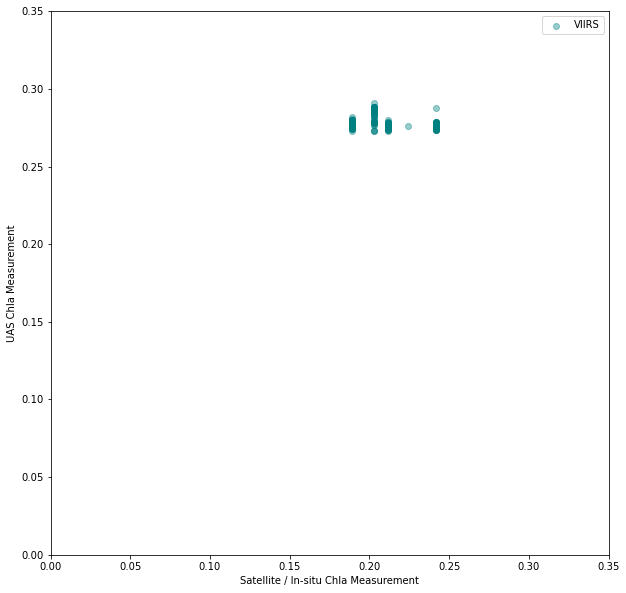

In [12]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(gdf3.viirs_chla, gdf3.chla, alpha=0.4, color='teal', label='VIIRS')
# ax.scatter(gdf_all_flights.modis_chla, gdf_all_flights.chla, alpha=0.3, color='blue', label='MODIS')
# ax.scatter(gdf_all_flights.olci_chla, gdf_all_flights.chla, alpha=0.3, color='green', label='OLCI')

# ax.scatter(insitu_gdf_front_cut.Chla, insitu_gdf_front_cut.uas_chla,  color='black', label='In-situ')
ax.set_ylabel('UAS Chla Measurement')
ax.set_xlabel('Satellite / In-situ Chla Measurement')
ax.set_ylim(.0,.35)
ax.set_xlim(0.0,.35)
ax.legend()
# ax.plot([0,1], [0,1], color='k', linestyle='--', linewidth=2, alpha=0.2)
# plt.savefig('sat_insitu_comparison.png', dpi=300)

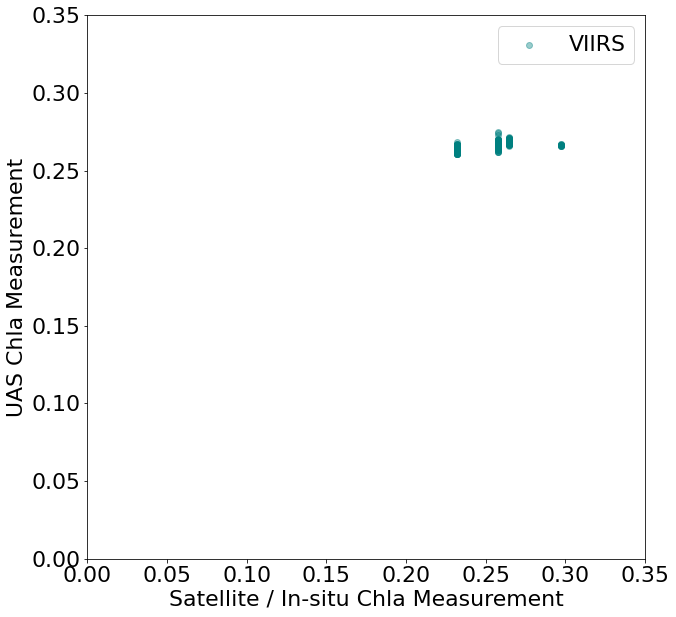

In [78]:
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(gdf2.viirs_chla, gdf2.chla, alpha=0.4, color='teal', label='VIIRS')
# ax.scatter(gdf_all_flights.modis_chla, gdf_all_flights.chla, alpha=0.3, color='blue', label='MODIS')
# ax.scatter(gdf_all_flights.olci_chla, gdf_all_flights.chla, alpha=0.3, color='green', label='OLCI')

# ax.scatter(insitu_gdf_front_cut.Chla, insitu_gdf_front_cut.uas_chla,  color='black', label='In-situ')
ax.set_ylabel('UAS Chla Measurement')
ax.set_xlabel('Satellite / In-situ Chla Measurement')
ax.set_ylim(.0,.35)
ax.set_xlim(0.0,.35)
ax.legend()
# ax.plot([0,1], [0,1], color='k', linestyle='--', linewidth=2, alpha=0.2)
# plt.savefig('sat_insitu_comparison.png', dpi=300)